<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/SiDet2023/IVScan_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [1]:
!pip install lmfit
from lmfit import Model
import sys
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.optimize import curve_fit

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'IVdata2023')
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

<ipython-input-2-217882b3f9df>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


#Process single file

In [3]:
#Function that returns the breakdown voltage using a parabola and linear fit
def getVbd(df, chan, debug = False):

    def log_func(x, a, b):
      return a*np.log(np.maximum(x + b, 0.00001))

    model = Model(log_func)
    params = model.make_params(a=2, b=-50.0)

    Vbr = df['Vbr'].iloc[0]
    x_ = df.query('V>%f & V<%f'%(Vbr+0.25, Vbr+1.)).V
    y_ = df.query('V>%f & V<%f'%(Vbr+0.25, Vbr+1.)).I_log
    result = model.fit(y_, params, x=x_)

    finex = np.arange(df.V.min(), df.V.max(), 0.01)
    f_par = log_func(finex, result.params['a'].value, result.params['b'].value)

    pedestal = np.mean(df.query('V<%f'%(Vbr-0.25)).I_log)
    f_lin = np.full(len(finex), pedestal)

    if debug:
        plt.figure()
        plt.plot(df.V.to_numpy(), df.I_log.to_numpy(), '-')
        plt.plot(finex, f_par, 'r-')
        plt.title("Channel: %d"%chan)
        plt.plot(finex, np.full(len(finex), pedestal), 'r-')
        plt.ylim(-1,5)


    idx = np.argwhere(np.diff(np.sign(f_par - f_lin))).flatten()
    return finex[idx][0]

<ipython-input-3-3456e572932e>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


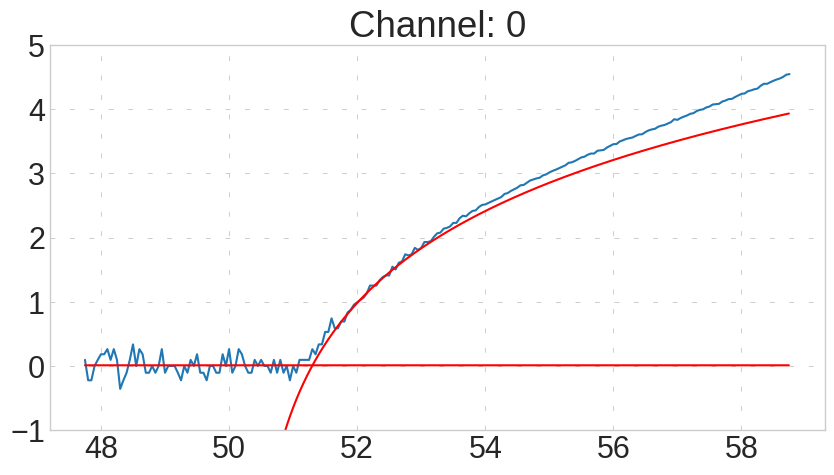

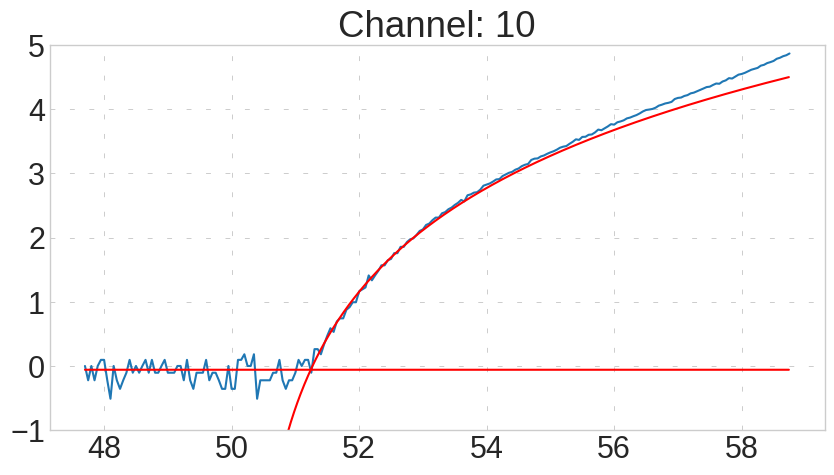

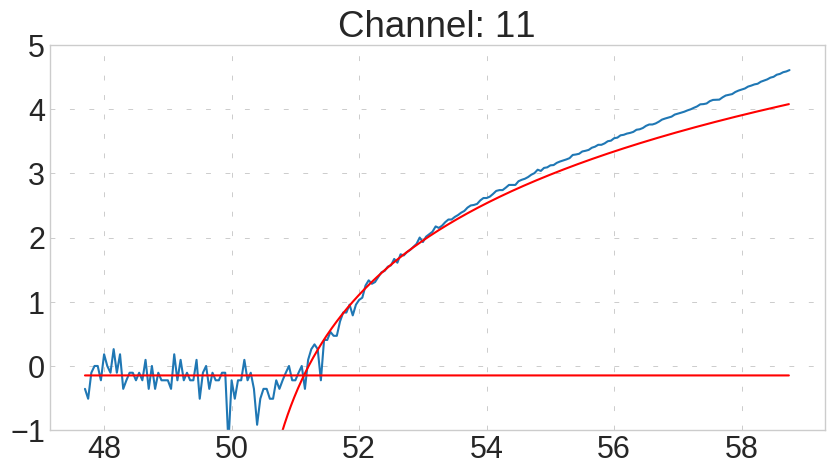

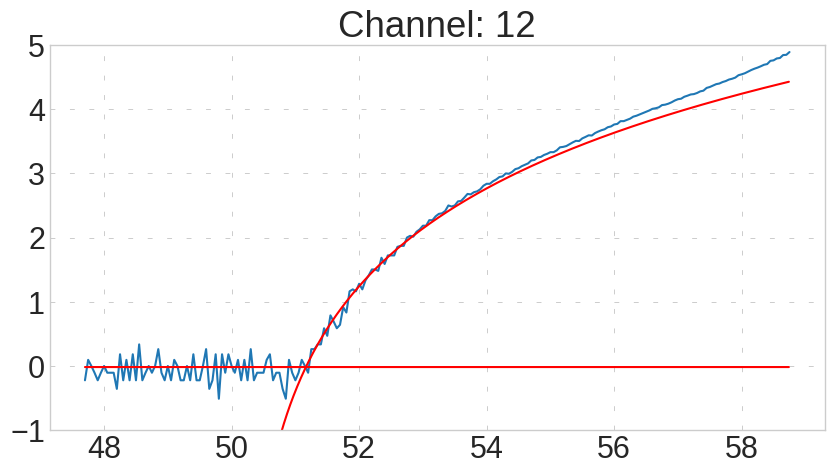

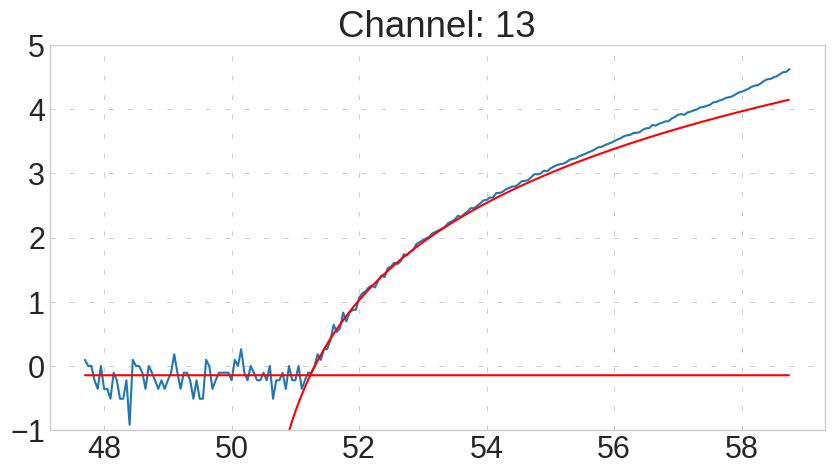

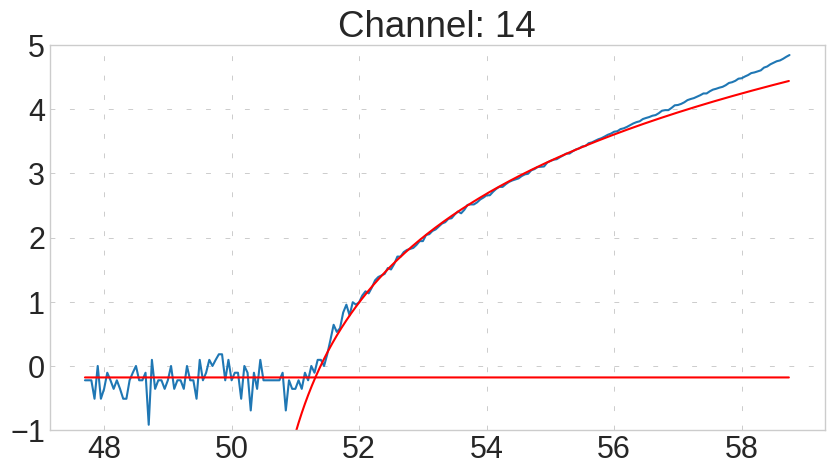

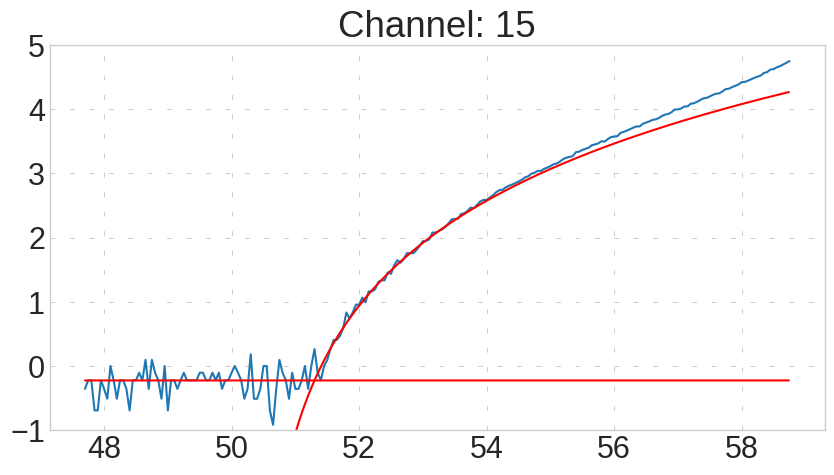

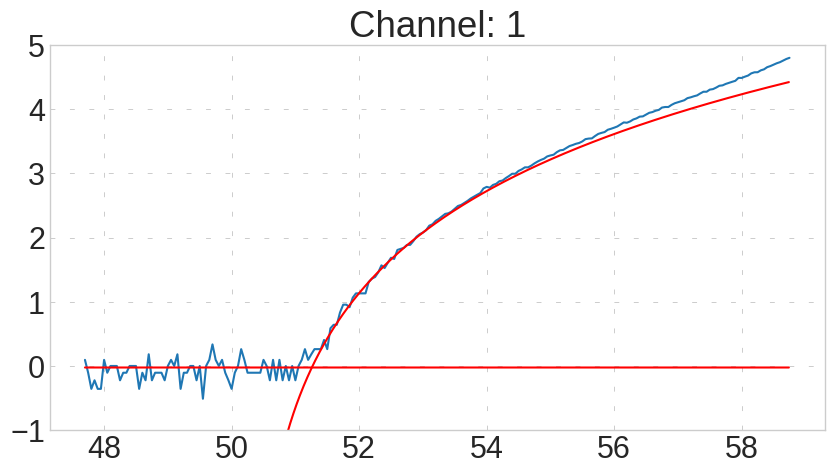

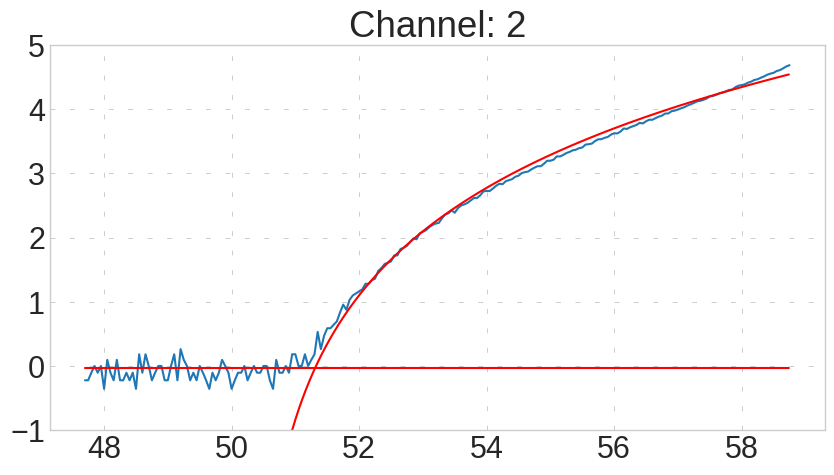

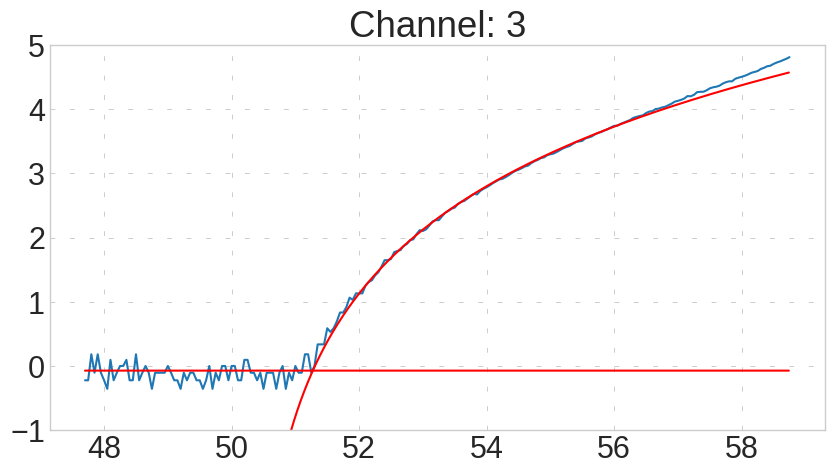

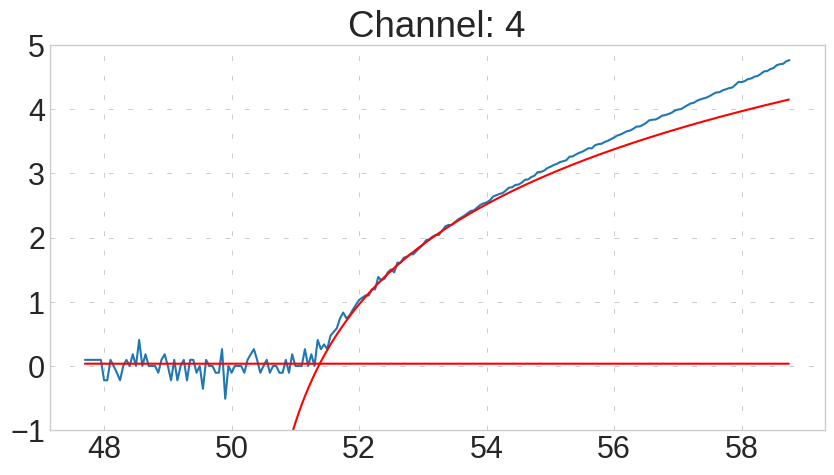

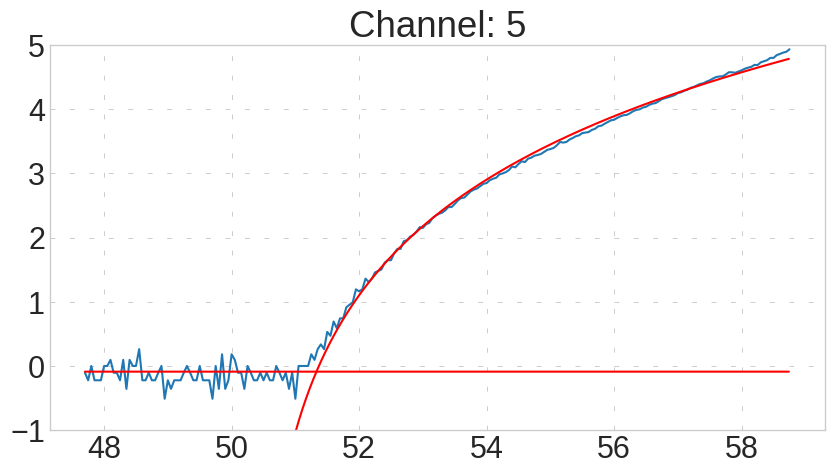

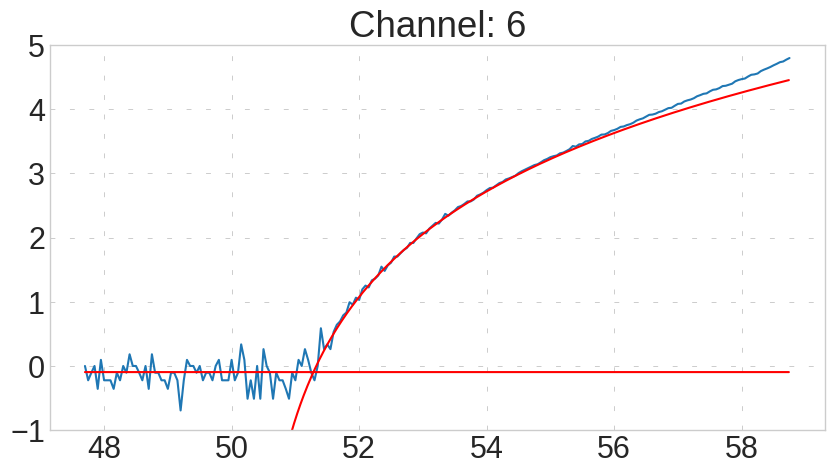

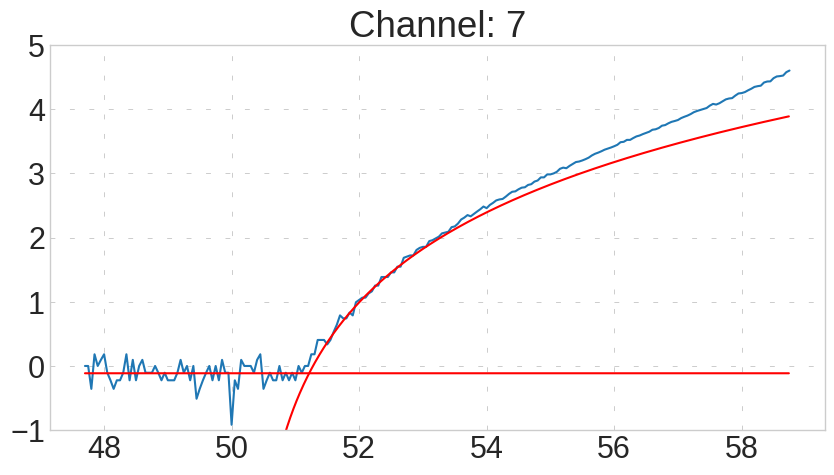

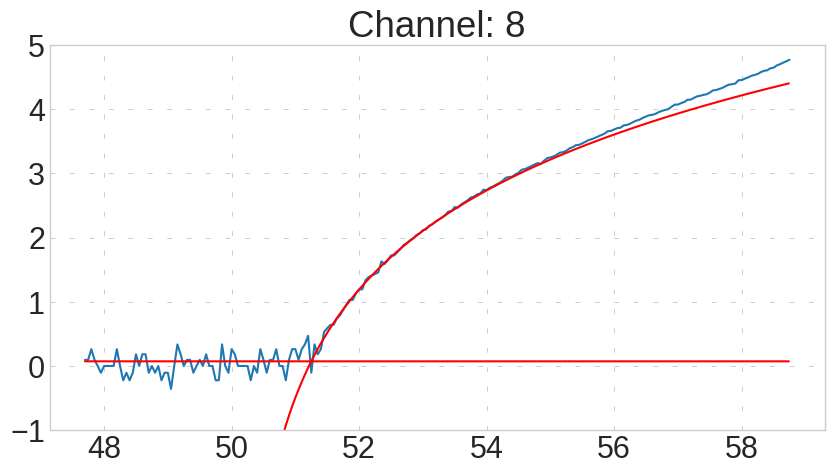

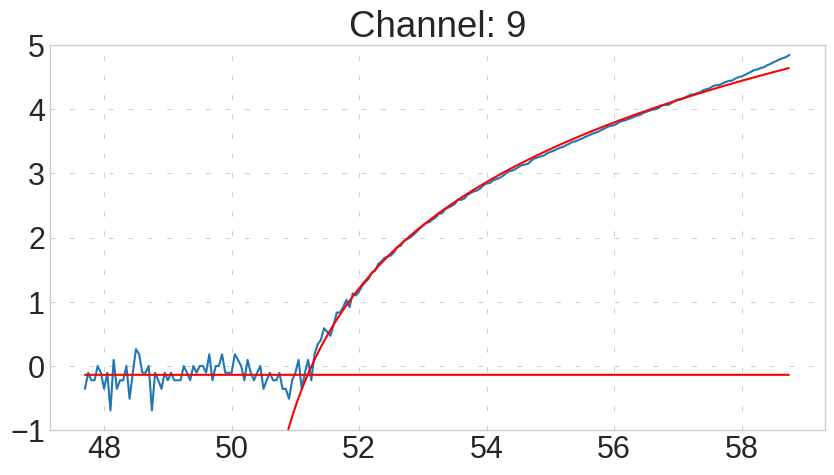

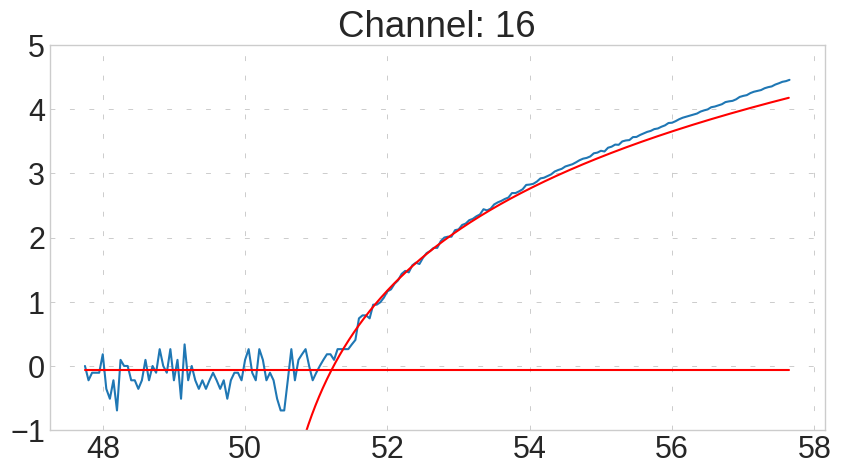

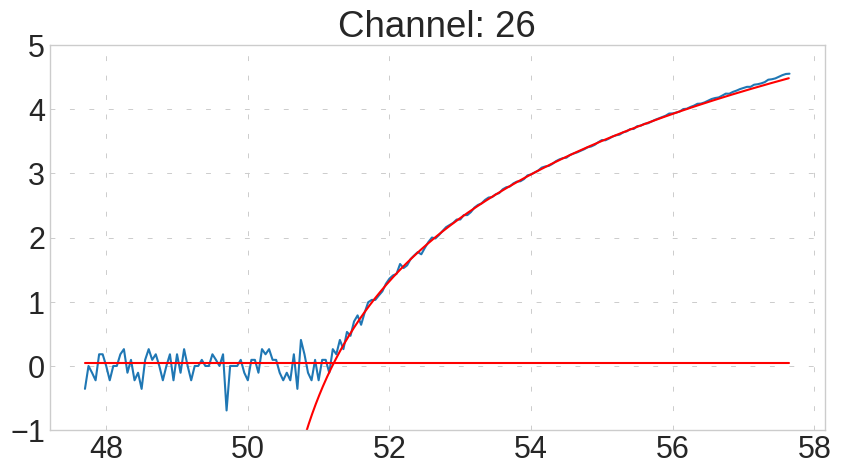

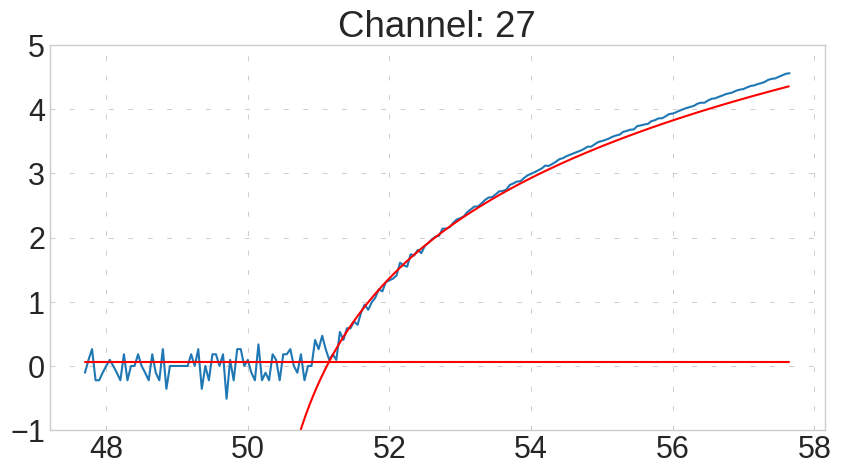

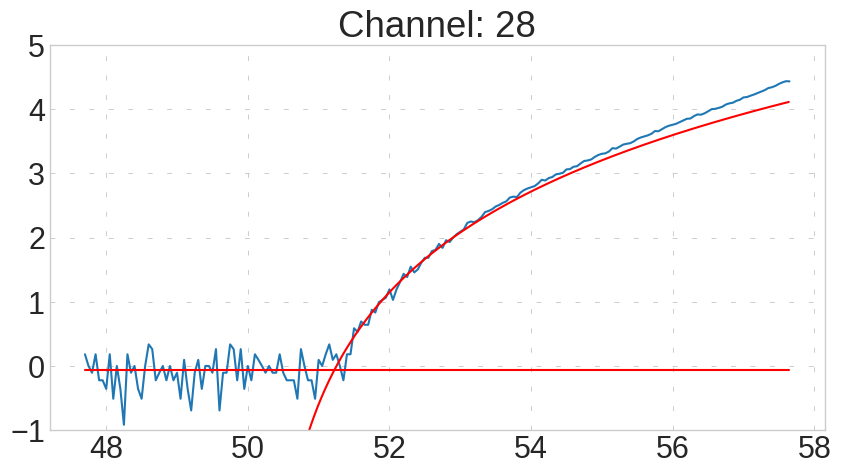

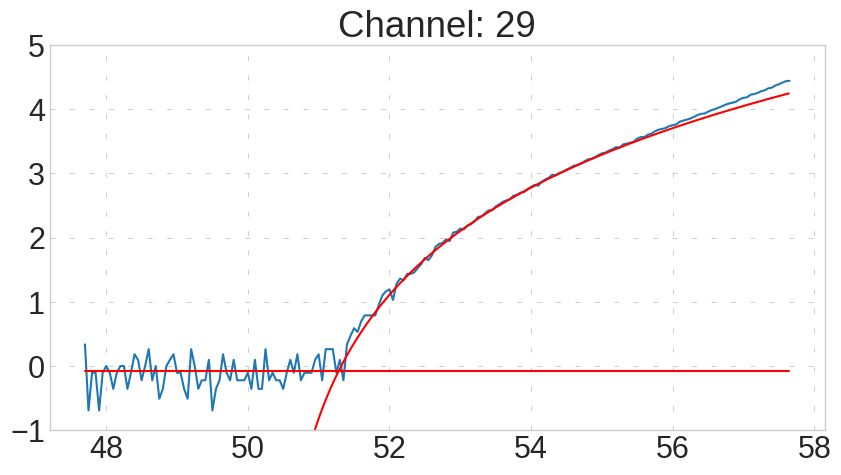

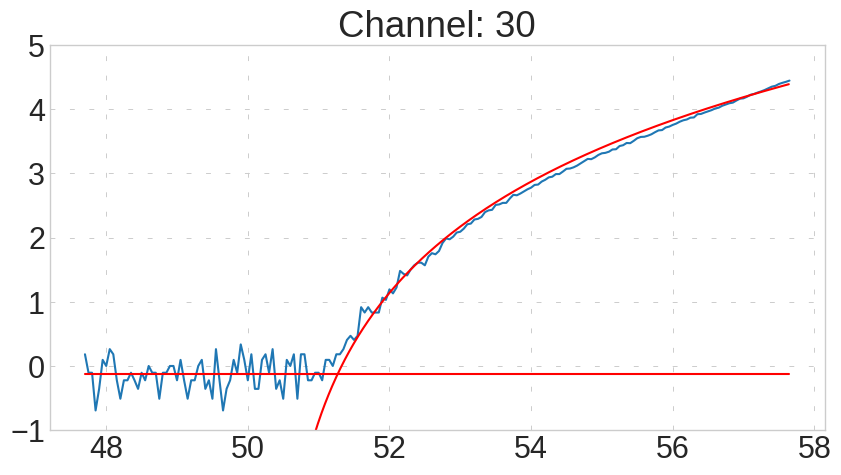

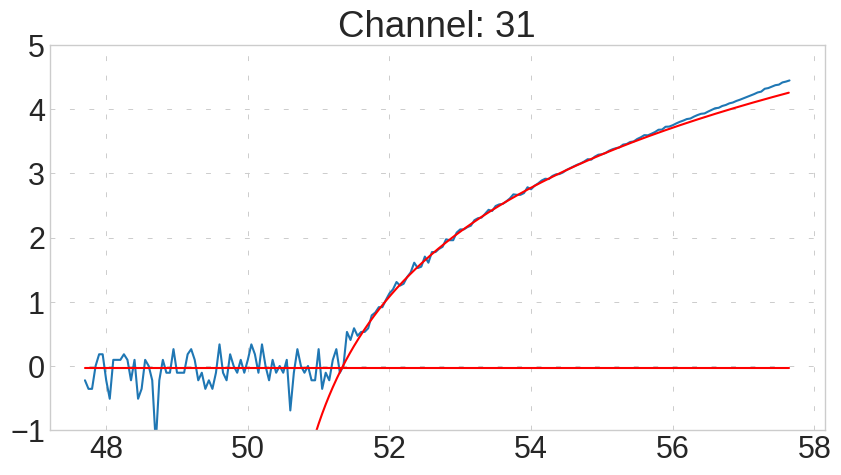

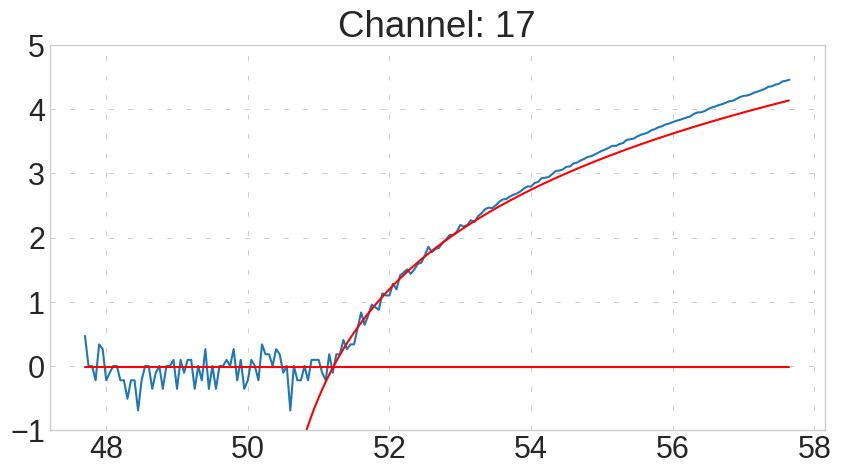

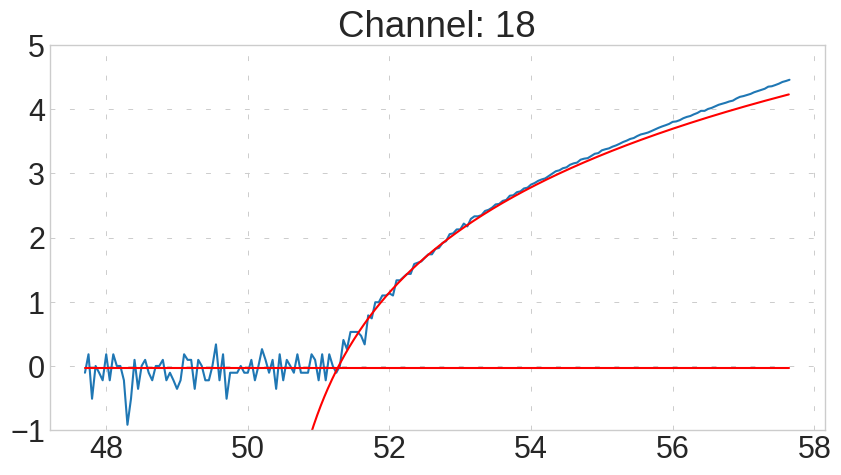

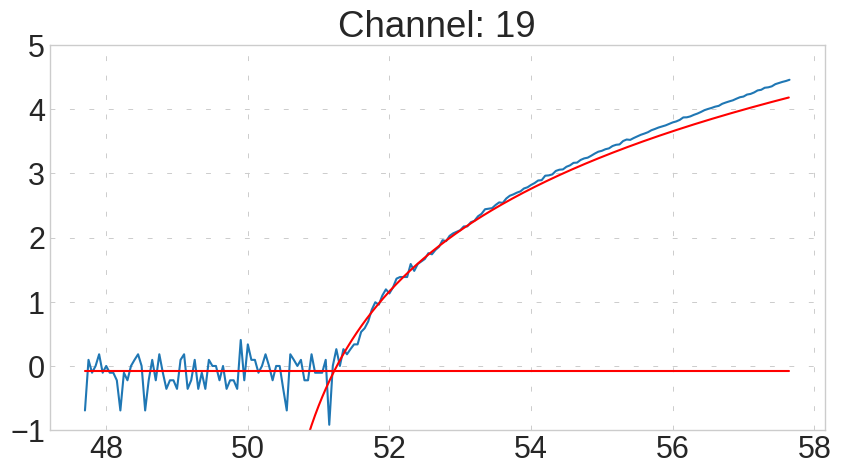

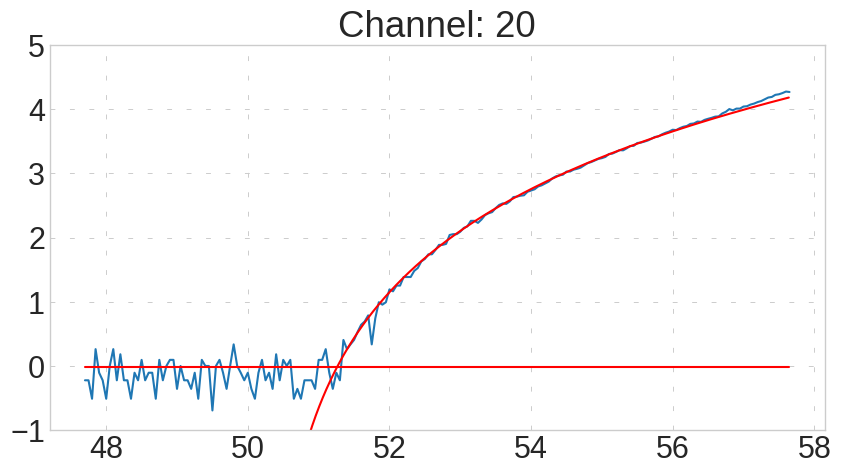

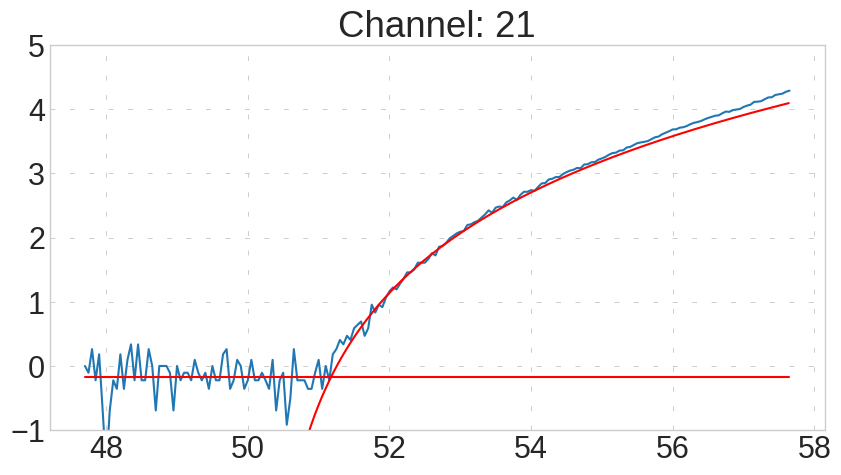

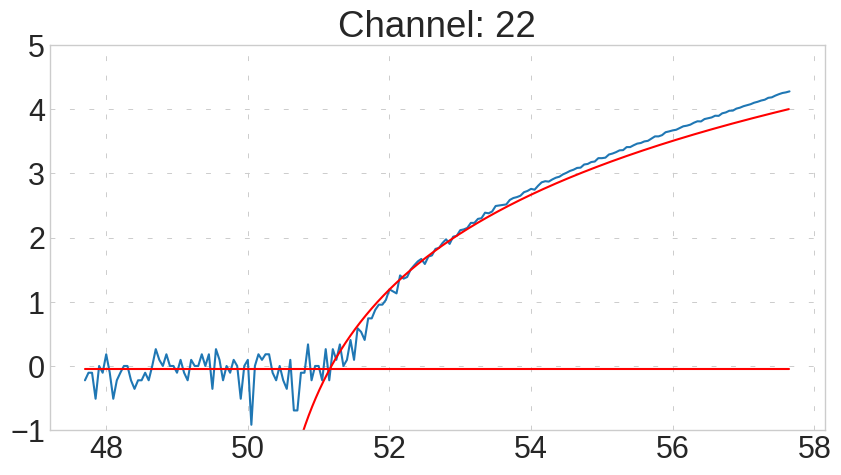

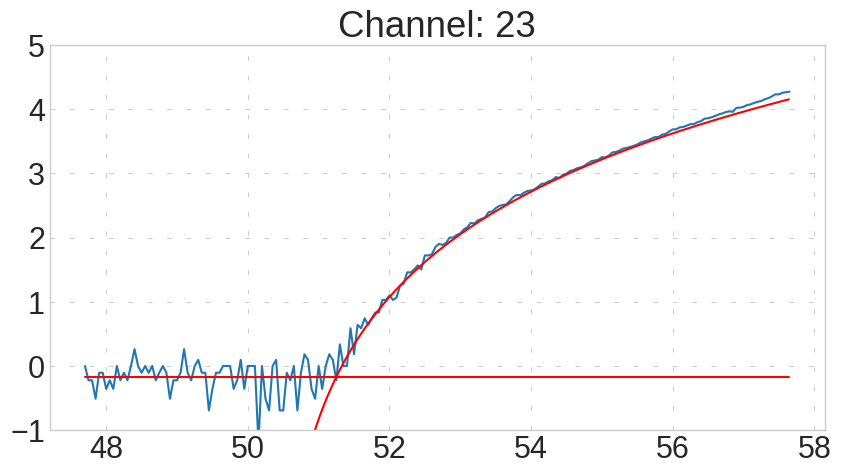

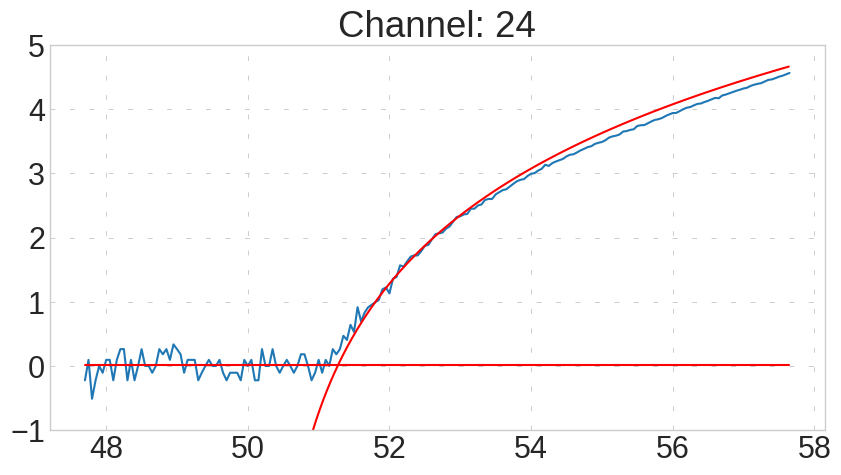

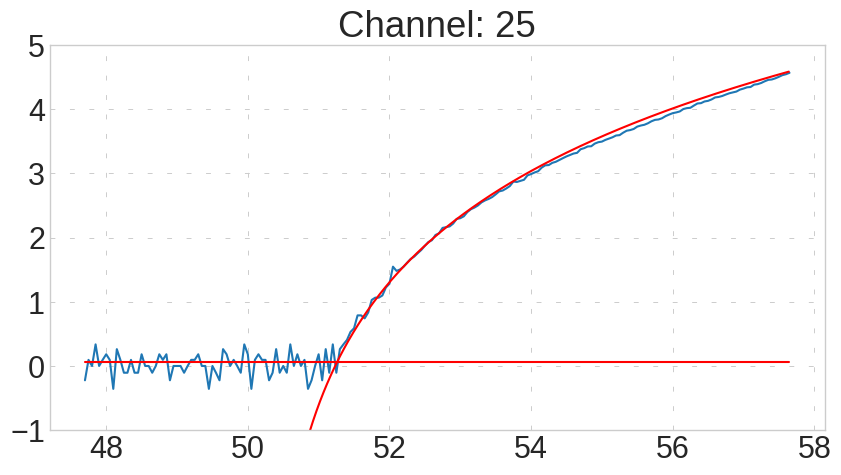

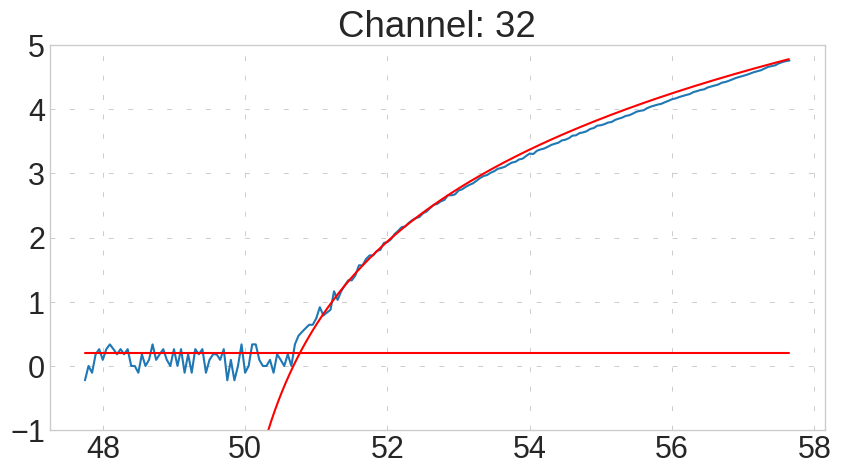

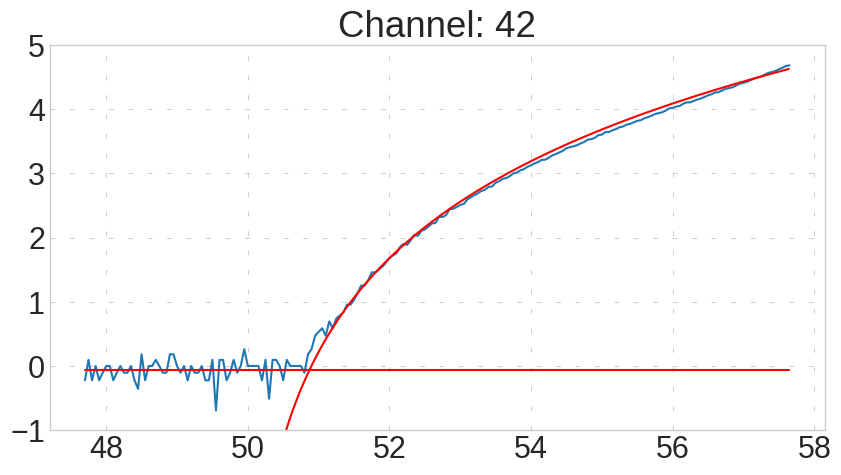

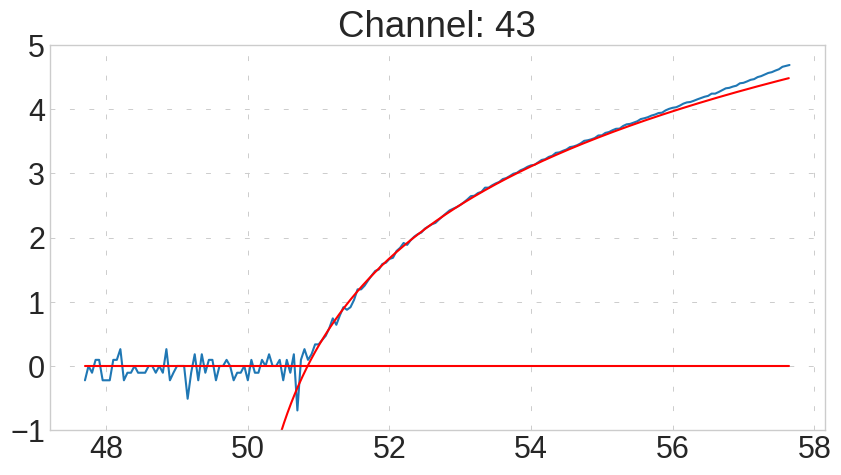

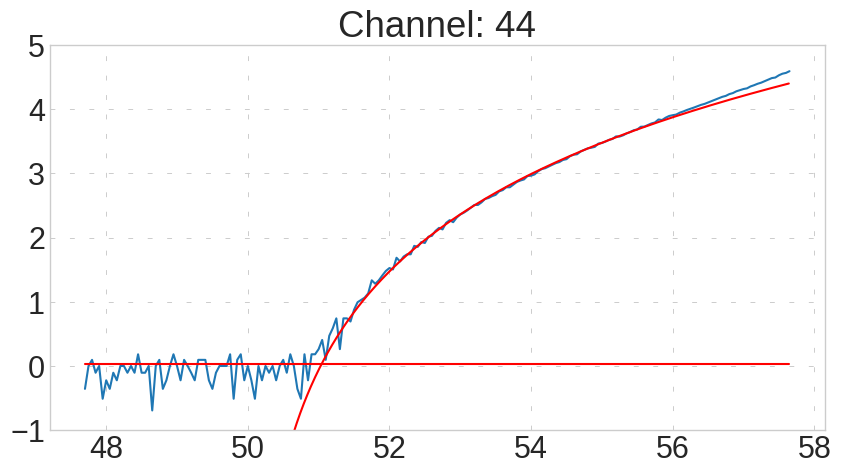

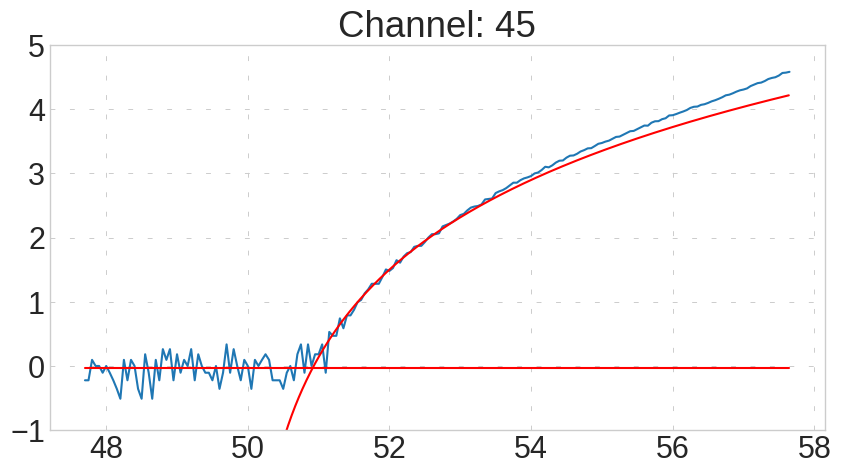

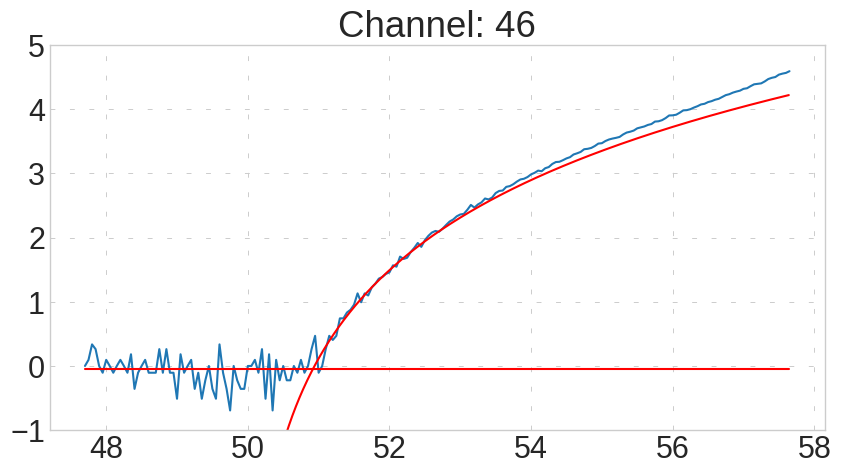

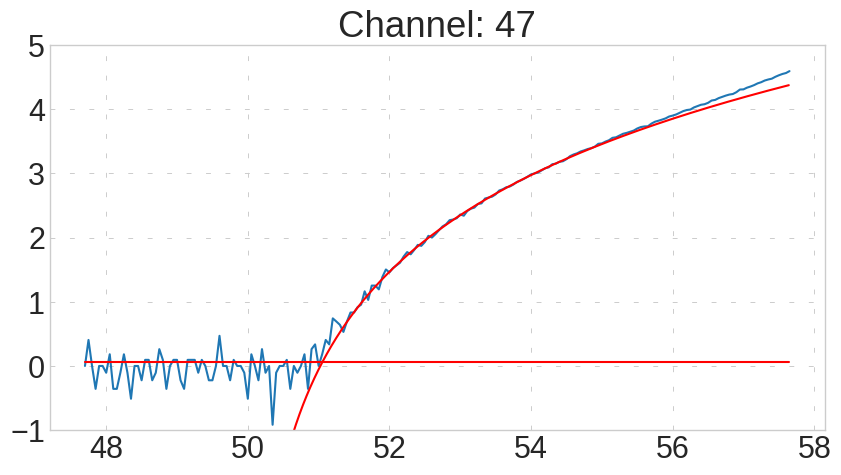

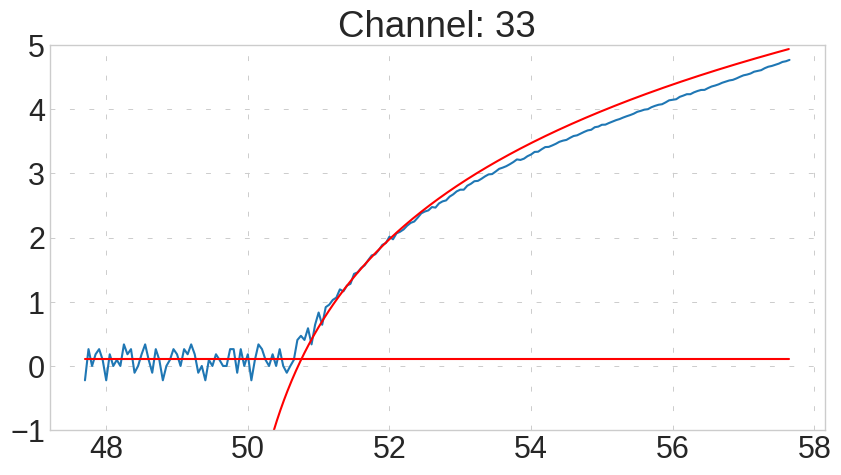

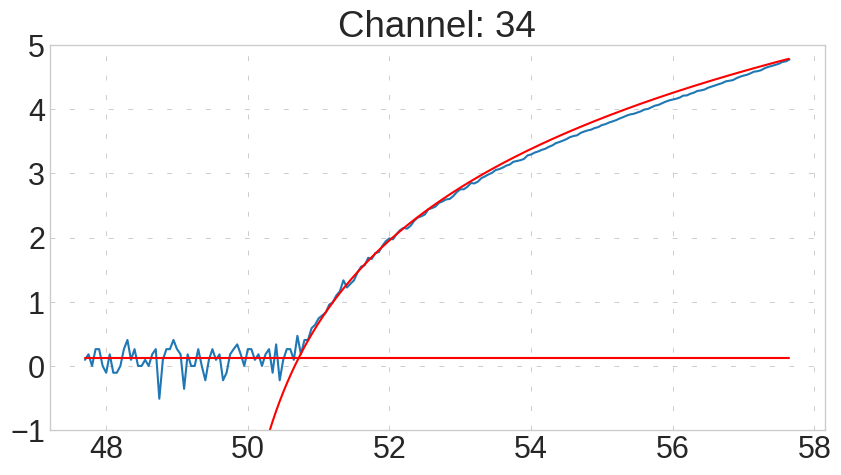

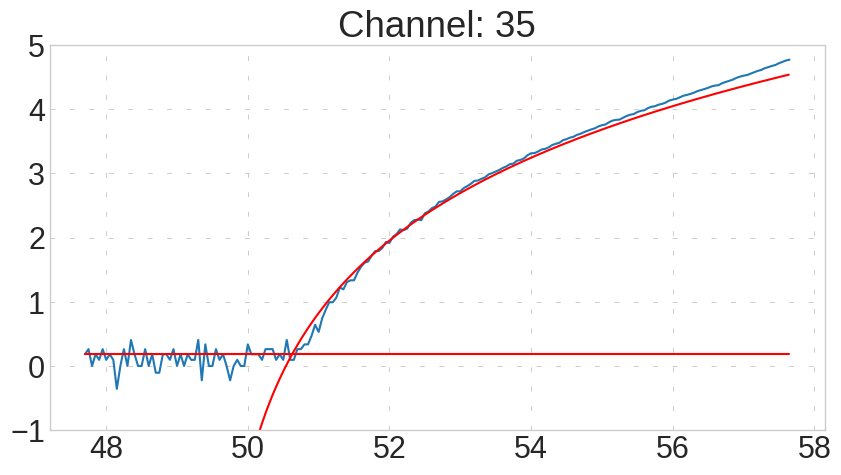

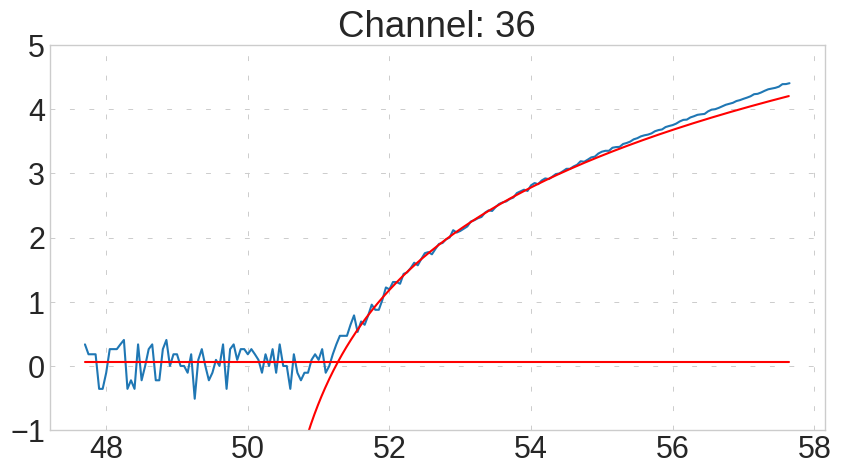

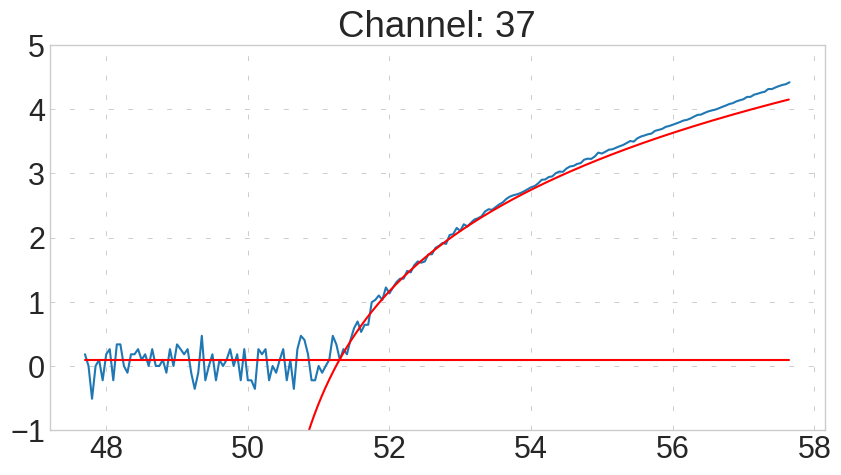

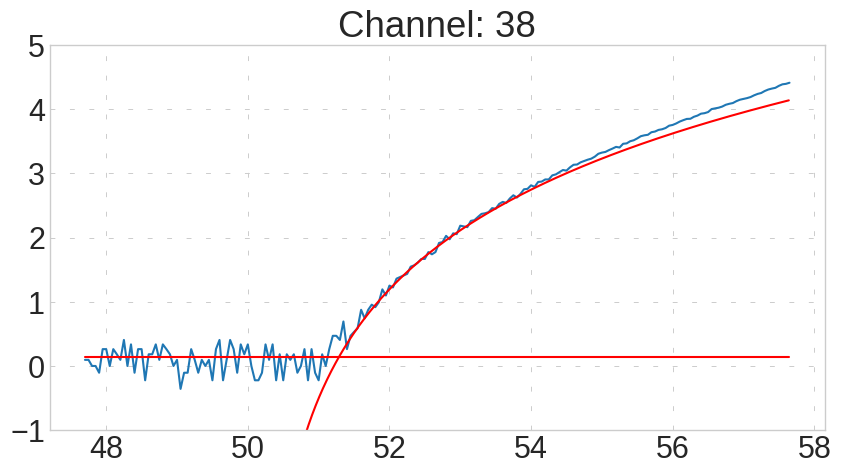

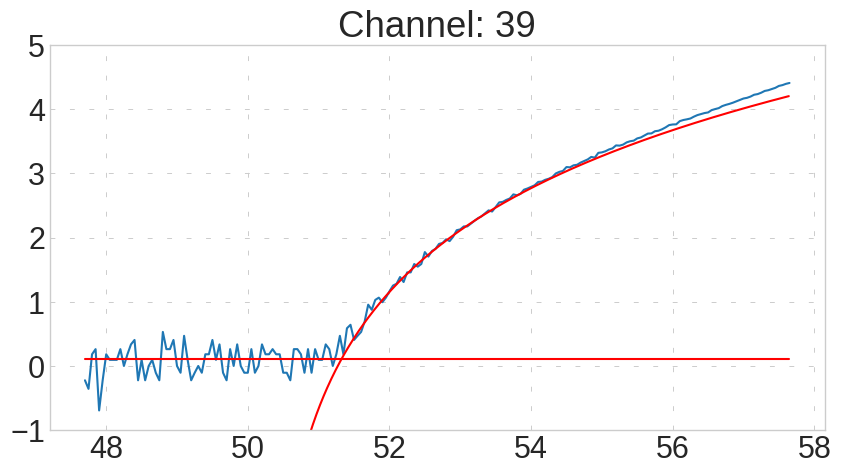

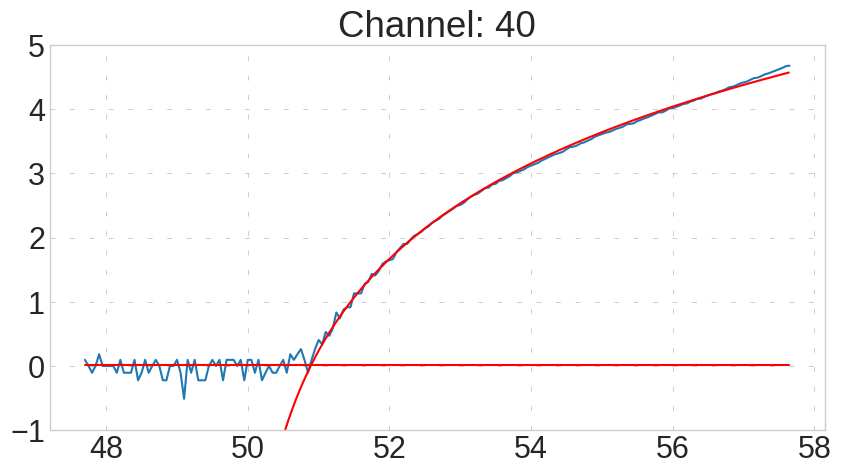

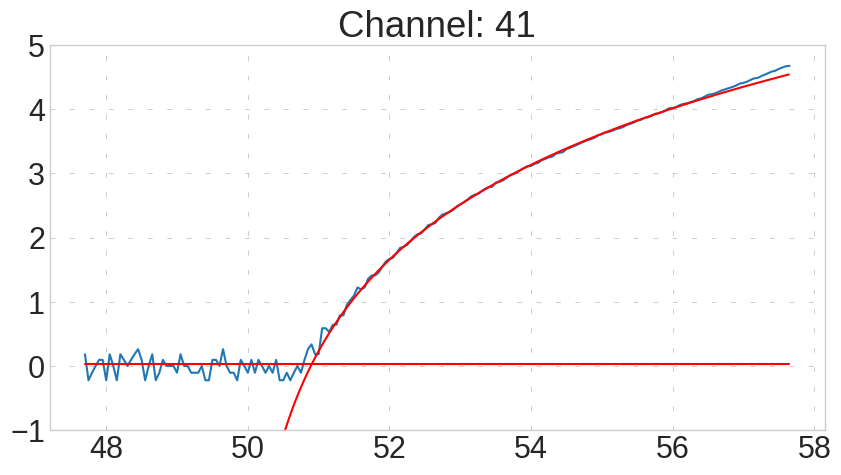

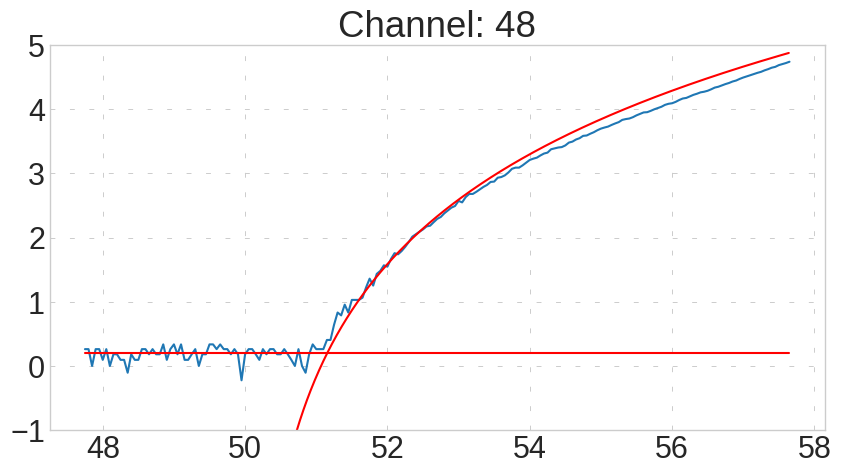

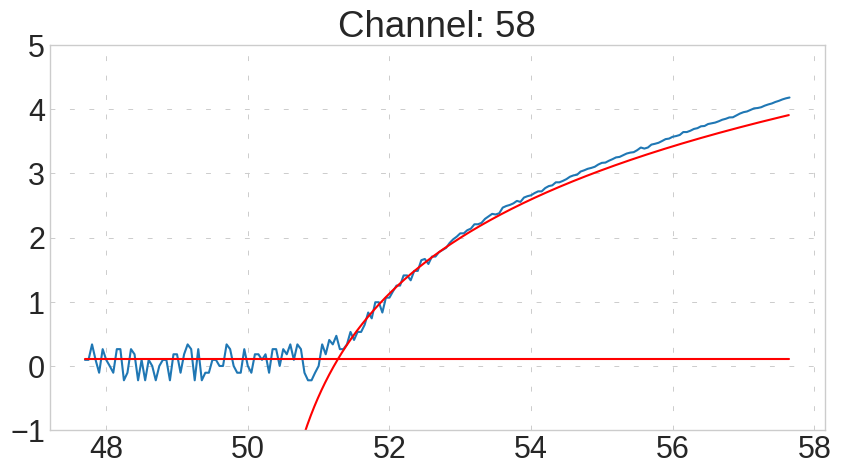

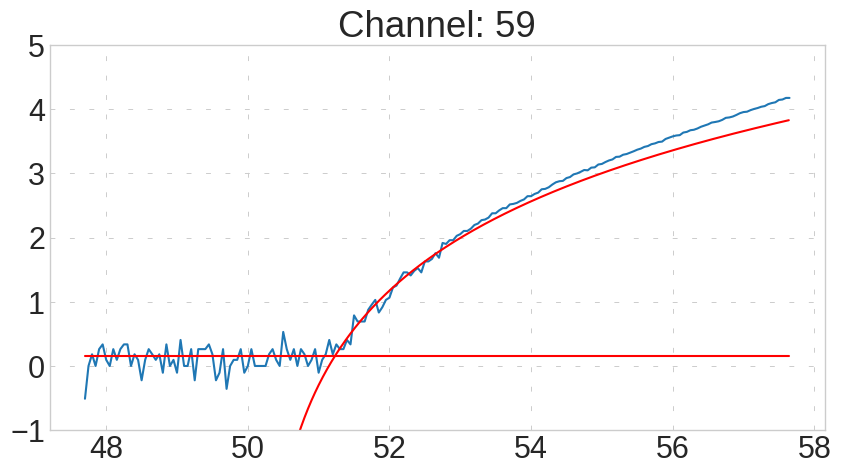

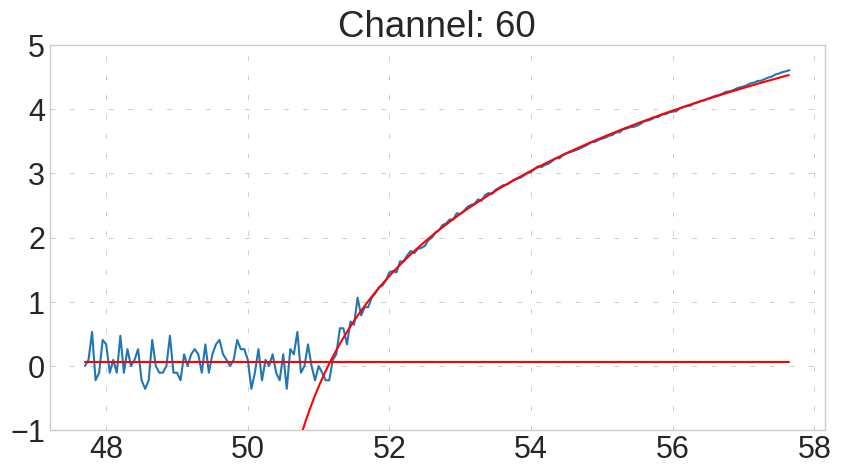

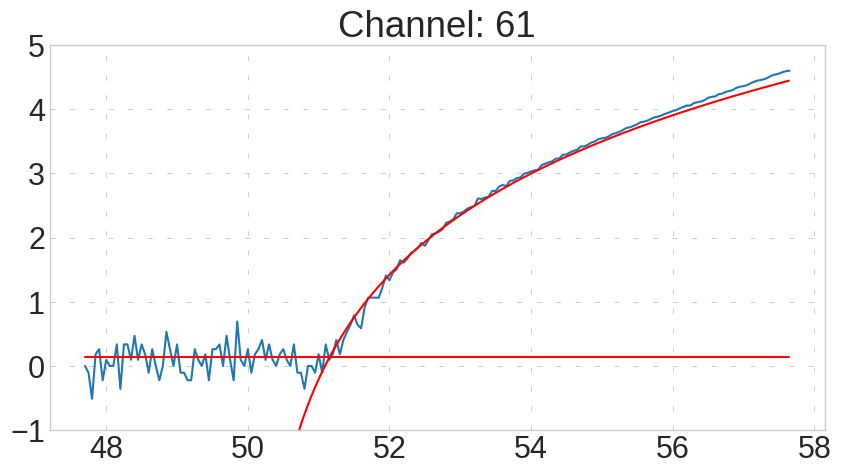

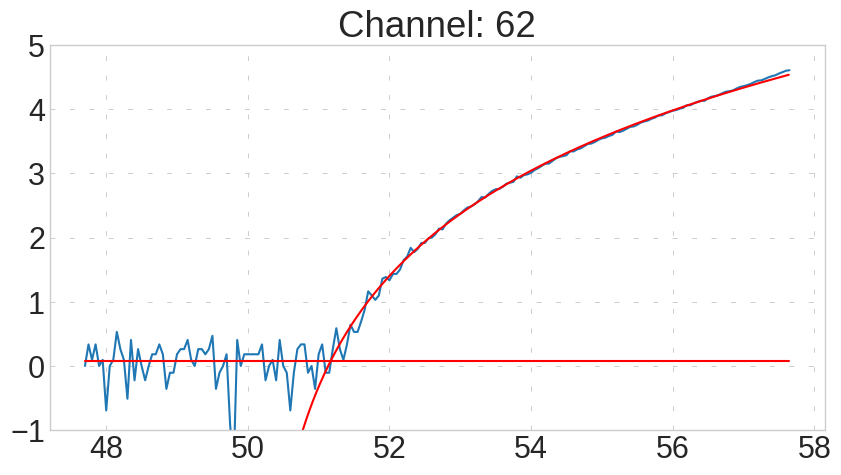

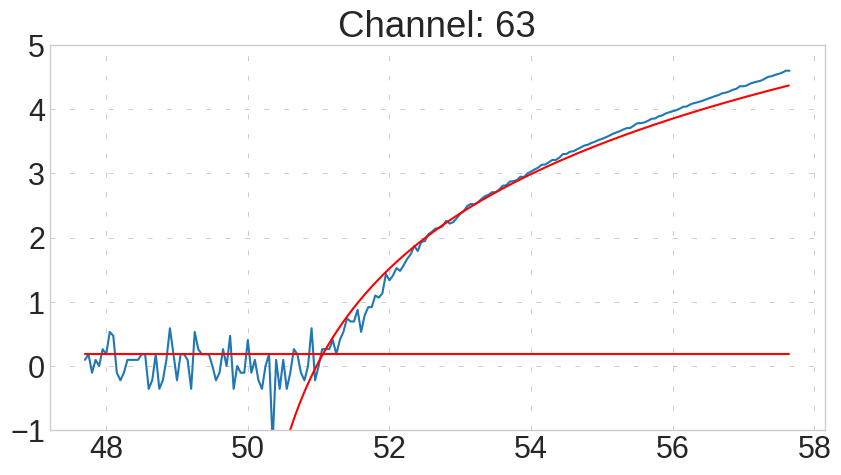

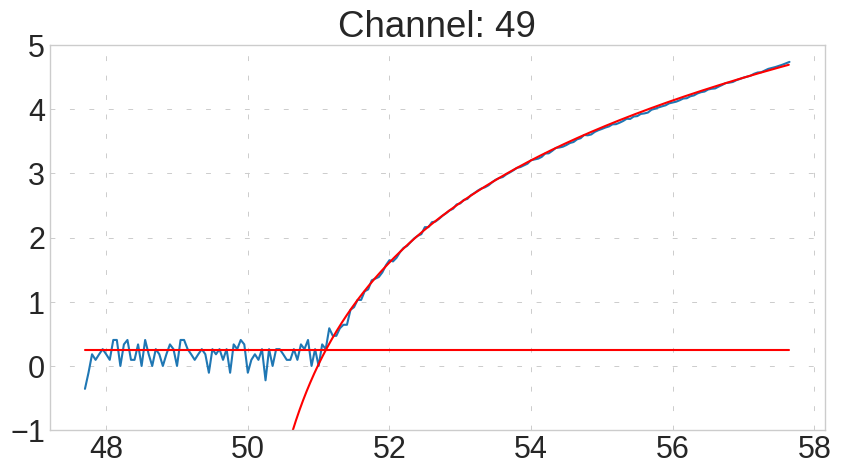

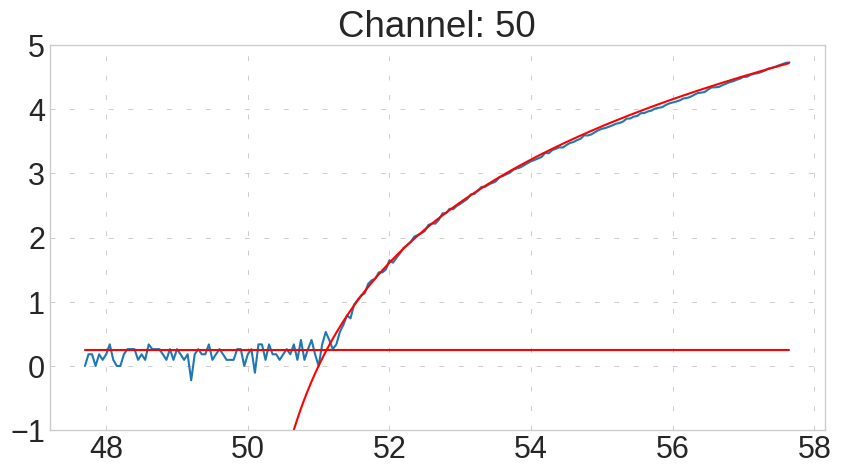

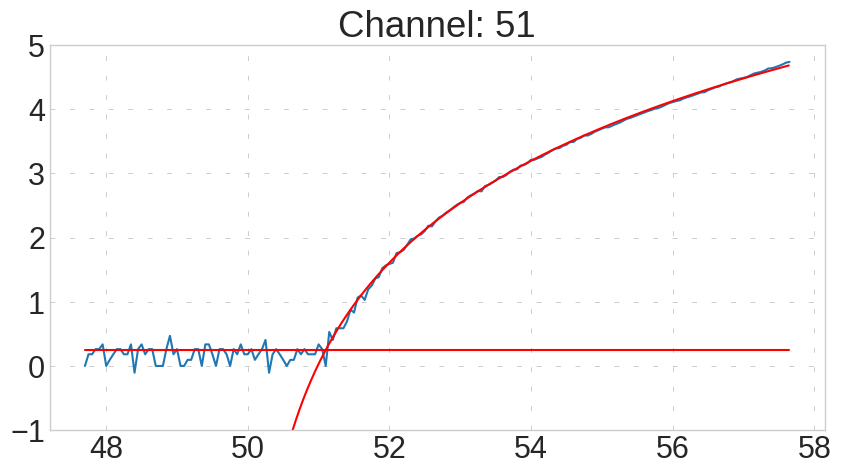

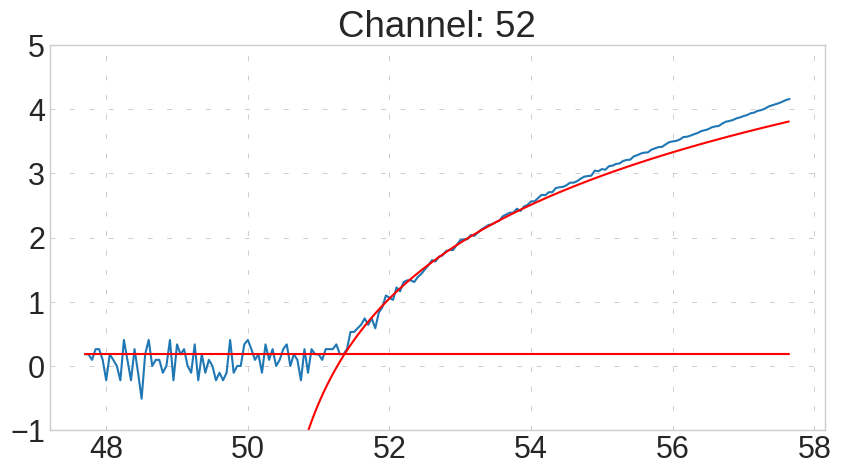

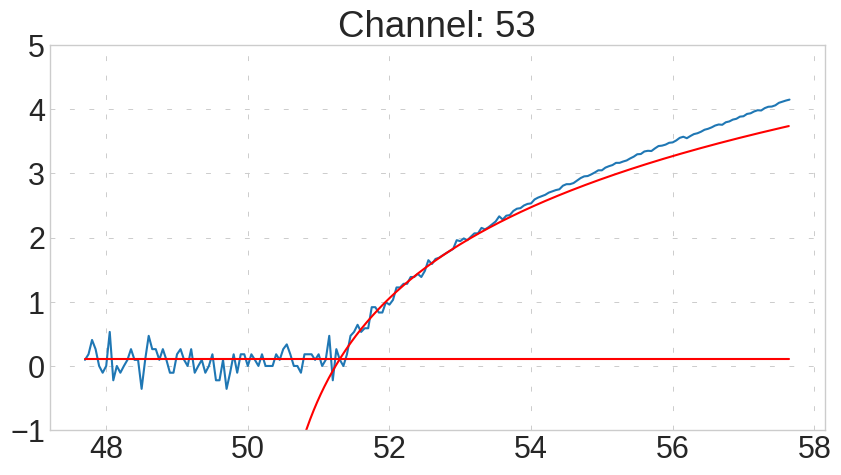

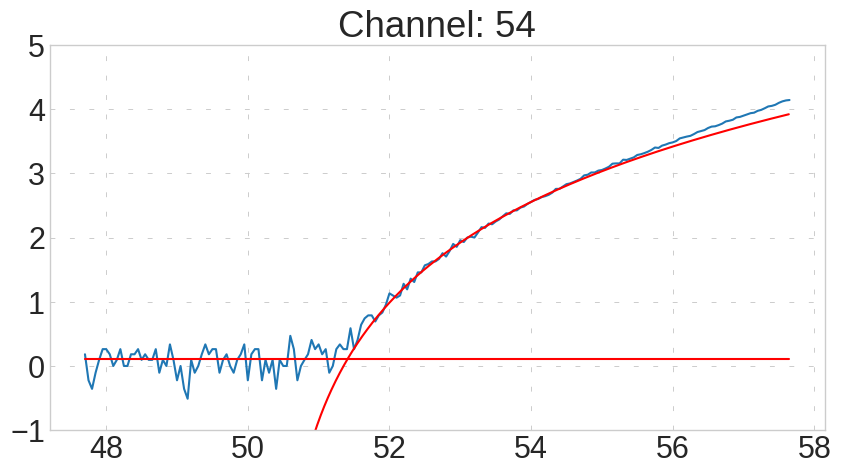

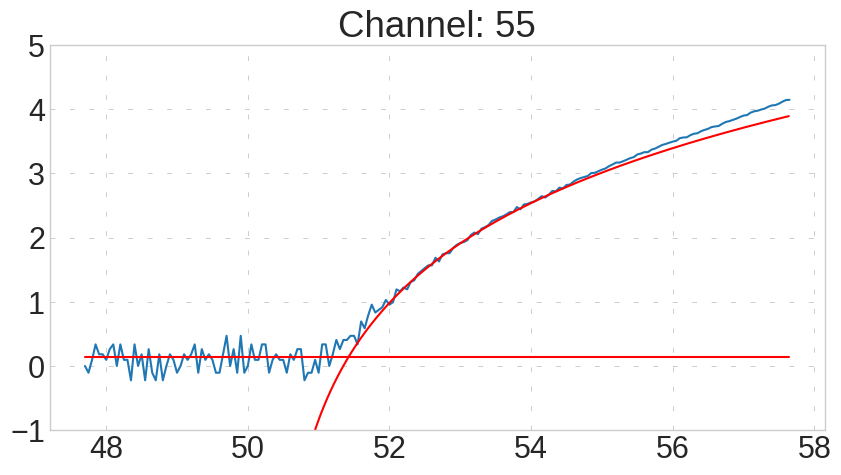

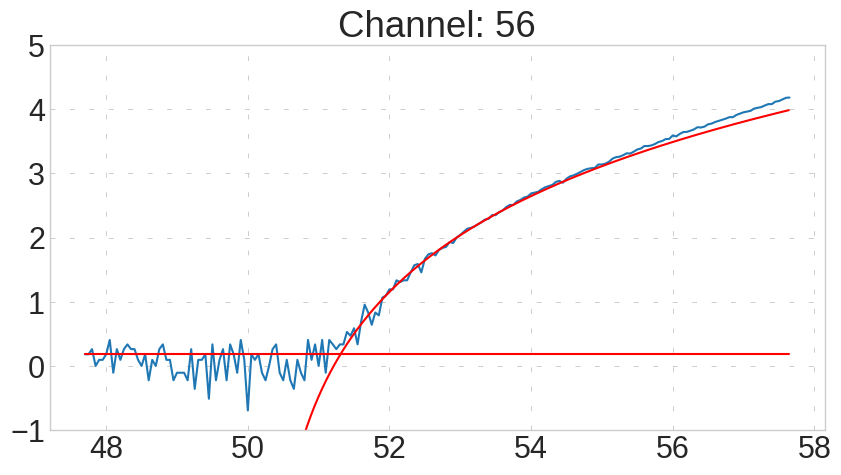

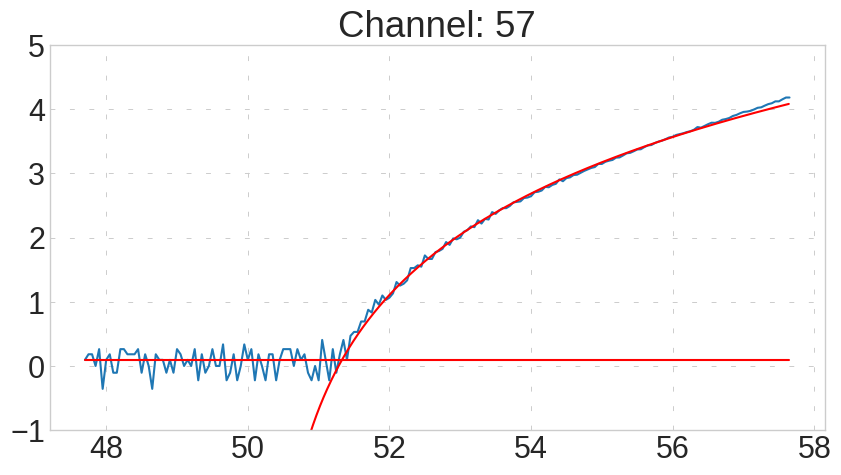

In [4]:
#Process a sinlge file from the tar file
df = pd.DataFrame()
file = 'drive/MyDrive/IVdata2023/etc.mu2e.CRV_wideband_cosmics.crviv-000.000010_000.tgz'
Temp = re.split('\.|_',file)[6].lstrip("0")
Temp = float(Temp)/100

with tarfile.open(file, 'r:gz') as tar:
    # Iterate over the files in the archive
    for member in tar.getmembers():
        # Extract the file
        if member.isdir():
            continue
        file = tar.extractfile(member)
        basename = os.path.basename(member.name)
        # Load the extracted file into a pandas DataFrame
        df_ = pd.read_csv(file, skiprows=8, header=0, names = ["V", "I"])  # Assuming the file is in CSV format
        split_name = basename.split("_")
        fpga = int(split_name[2][4:])
        chan = int(split_name[3][2:])
        df_['fpga'] = fpga
        df_['chan'] = chan + 16*fpga
        df_['I_log'] = np.log(df_['I'])
        df_['Temp'] = Temp*100
        # Calculate dLod(I)/dV to estimate the breakdown voltage
        df_coarse = df_.groupby(df_.index // 8).mean()
        df_['Vbr'] = df_coarse['V'][df_coarse['I_log'].diff().idxmax()]
        Vbr_fit = getVbd(df_, chan + 16*fpga, True)
        df_['Vbr_fit'] = Vbr_fit
        df = pd.concat([df,df_], ignore_index=True)

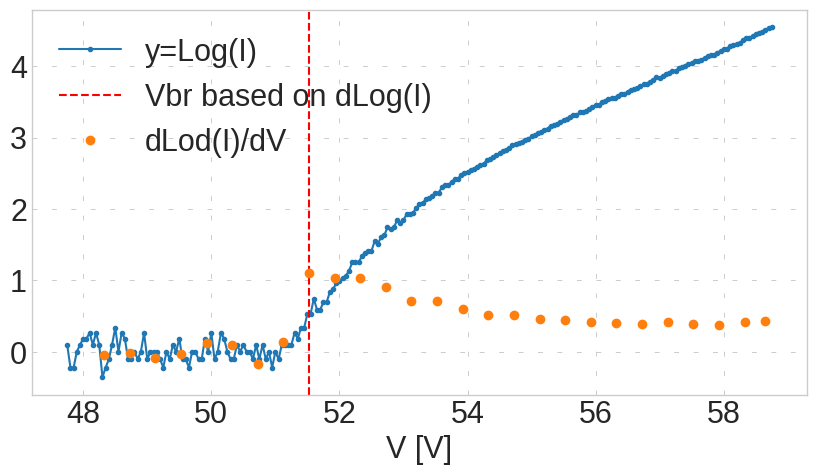

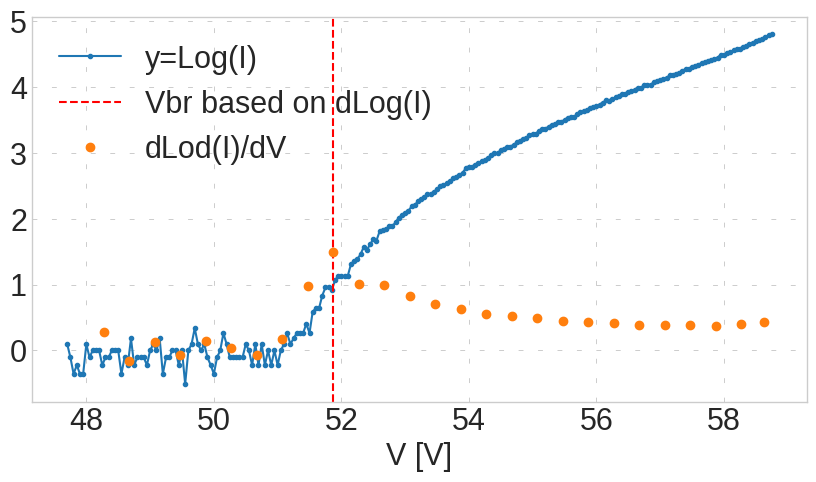

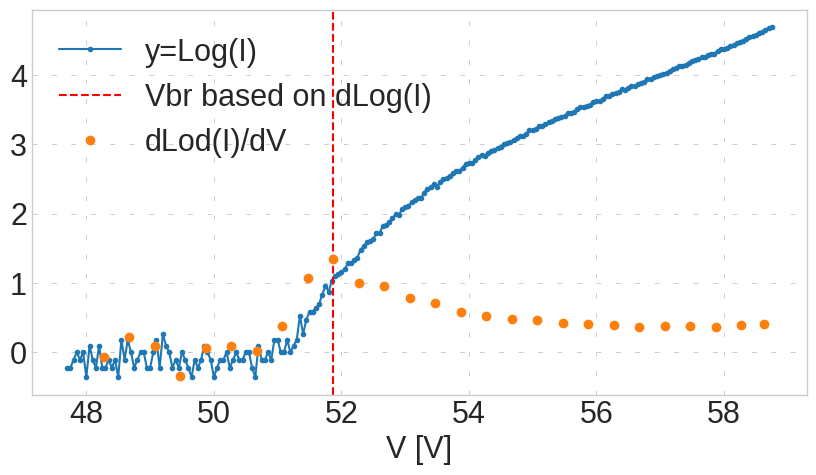

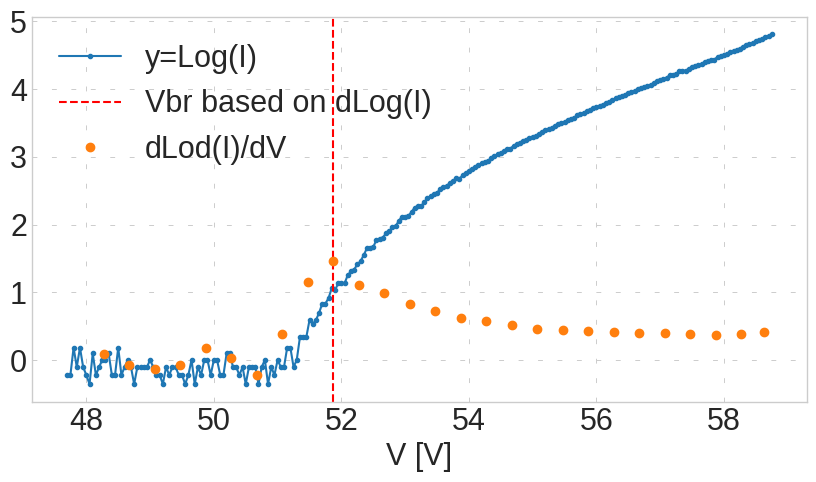

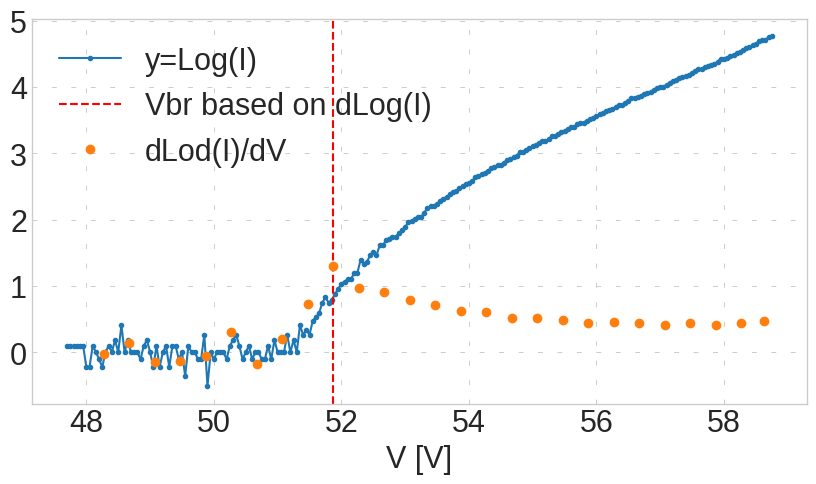

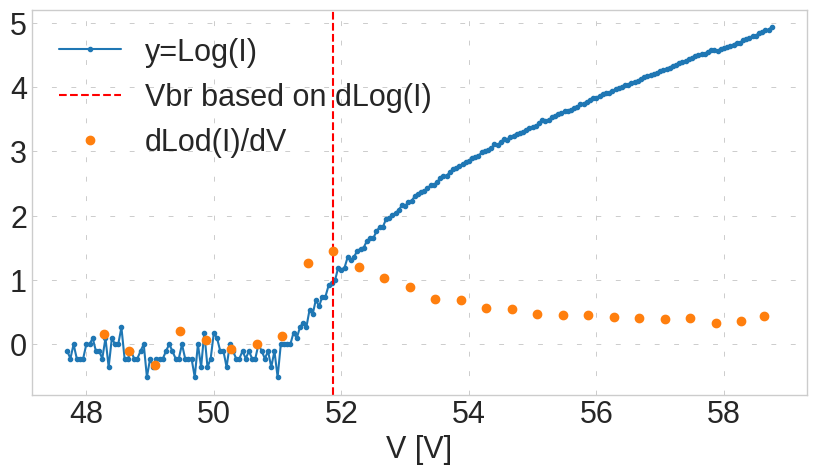

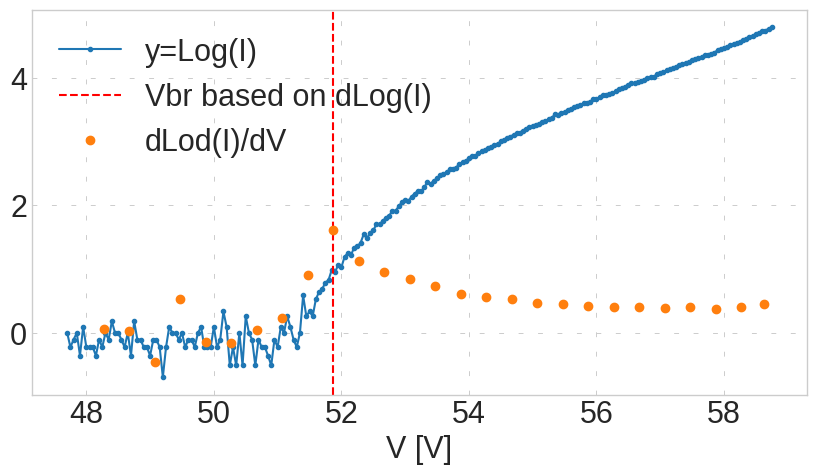

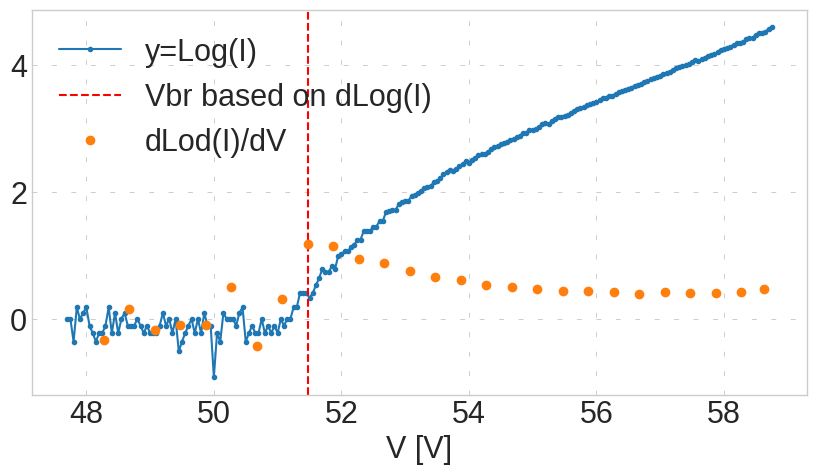

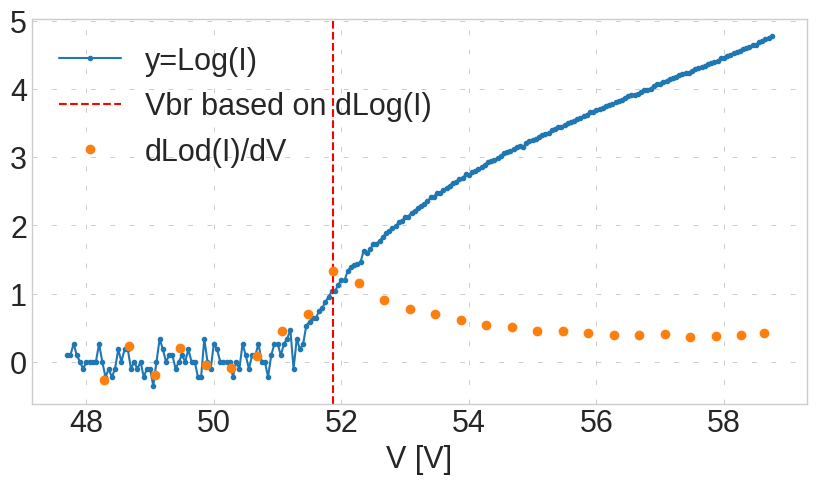

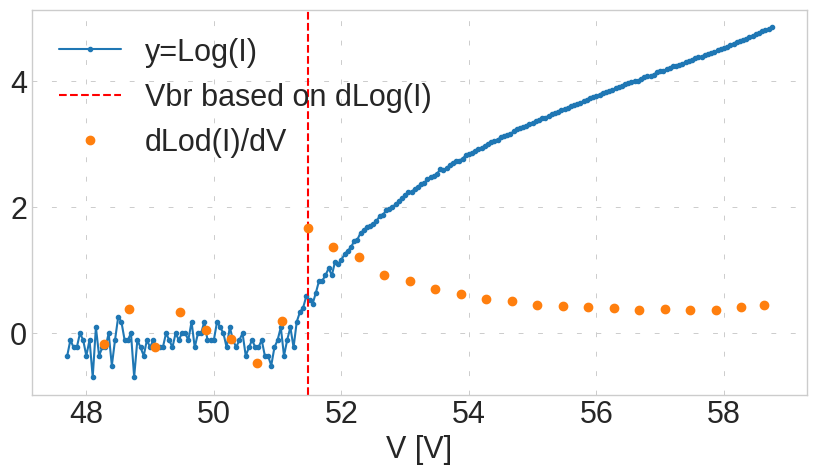

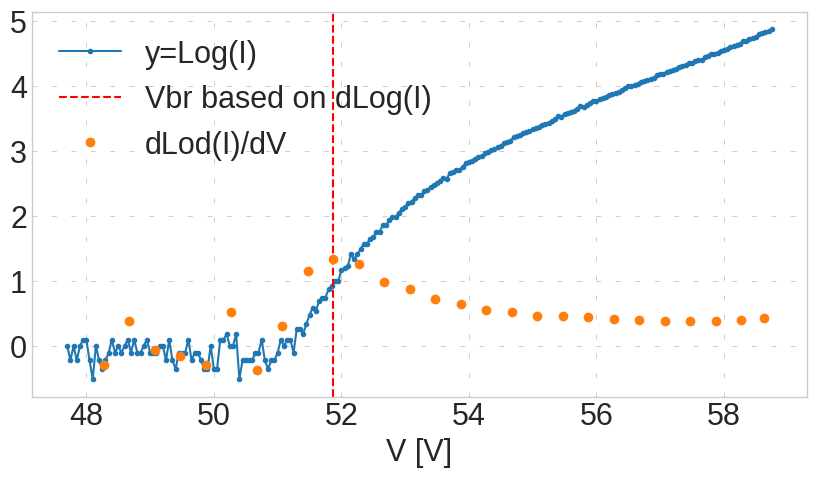

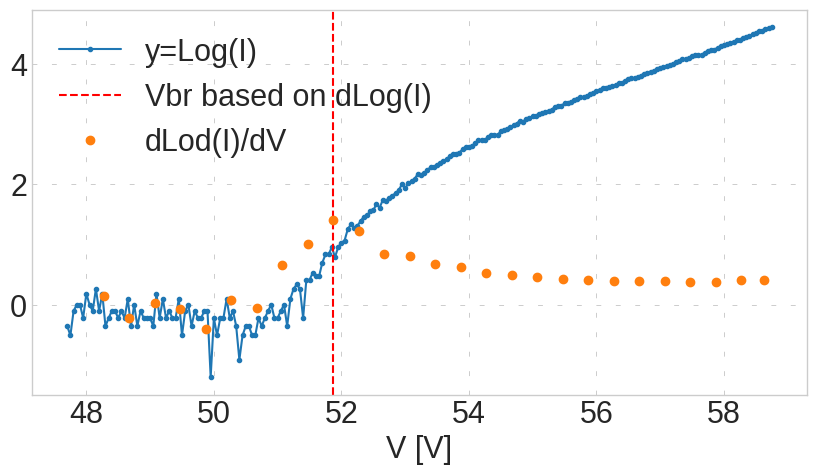

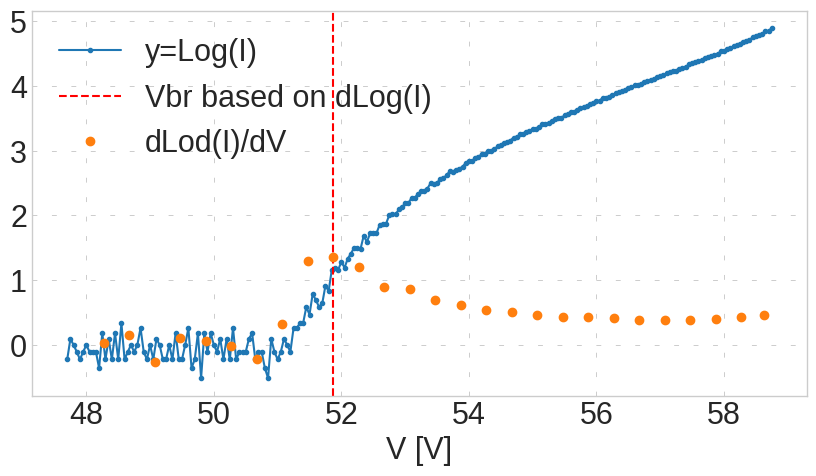

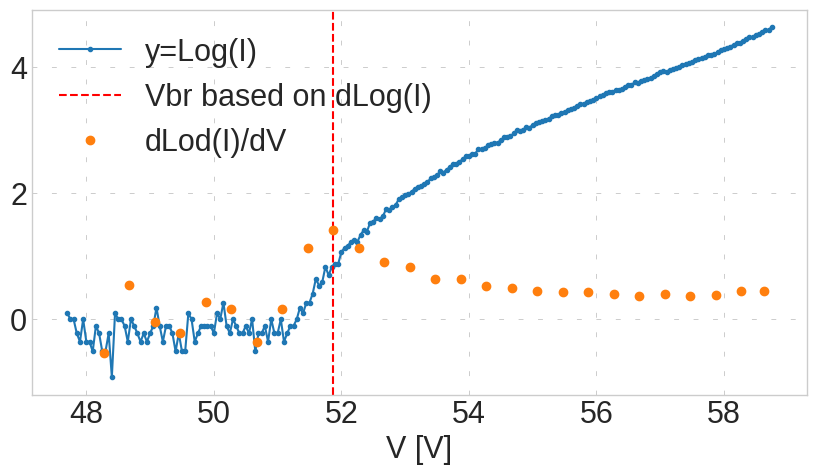

In [5]:
for chan in range(14):
  plt.figure()
  #Plot a single channel
  df1 = df.query("chan==%d"%chan).reset_index()
  plt.plot(df1.V, df1.I_log, '.-', label='y=Log(I)');
  plt.axvline(x=df1.Vbr[0], color='red', linestyle='--', label='Vbr based on dLog(I)')
  #plt.axvline(x=df1.Vbr_fit[0], color='red', linestyle='-.', label='Vbr based on fit')

  df_coarse = df1.groupby(df1.index // 8).mean()
  plt.plot(df_coarse['V'], df_coarse['I_log'].diff()/df_coarse['V'].diff(), 'o', label='dLod(I)/dV')
  plt.legend()
  plt.xlabel("V [V]")

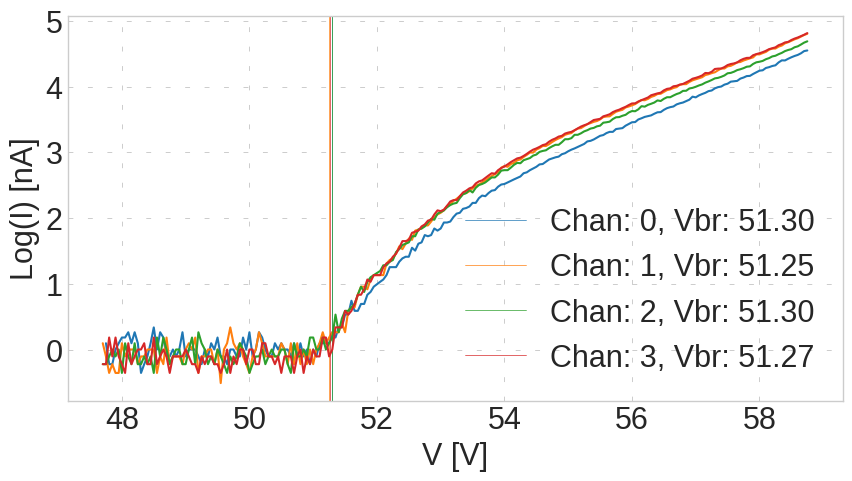

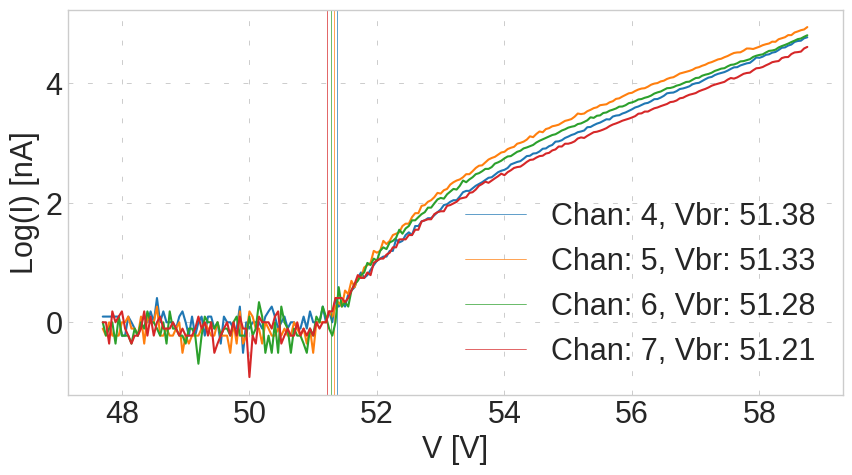

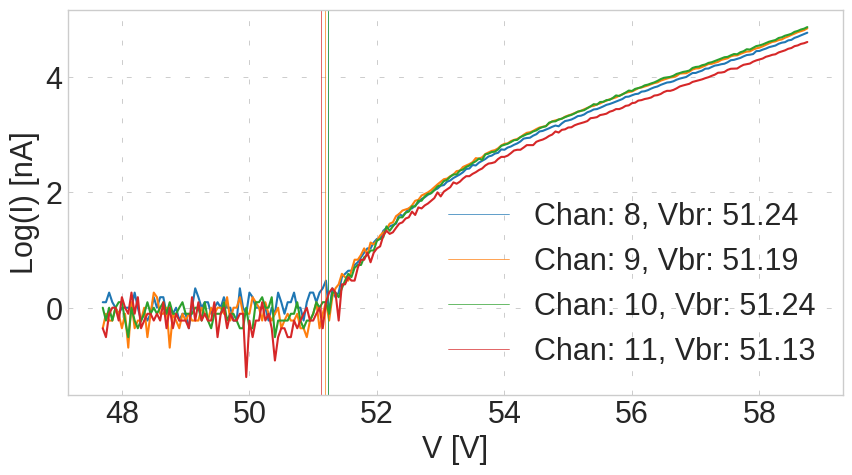

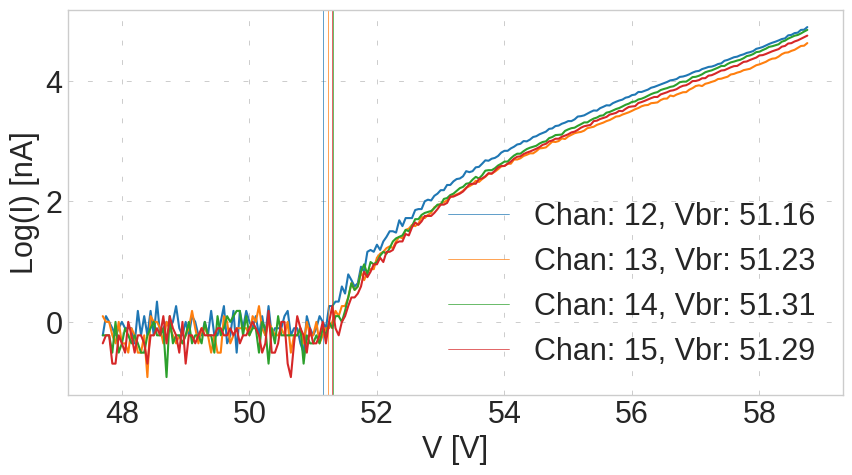

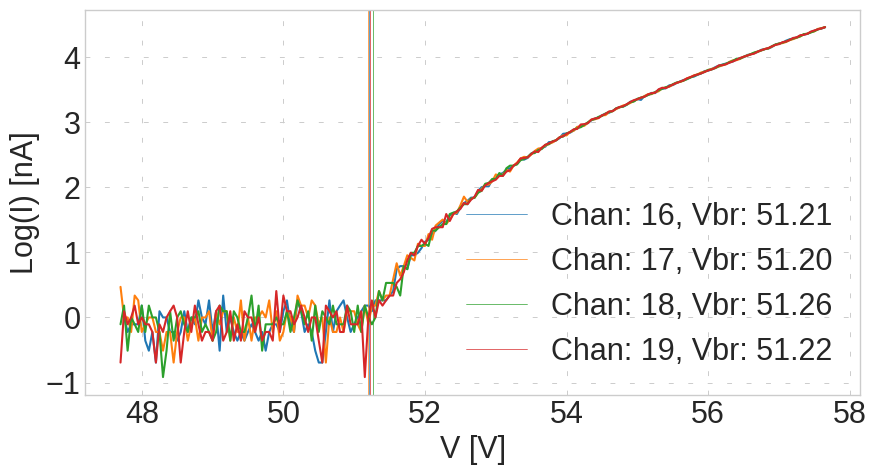

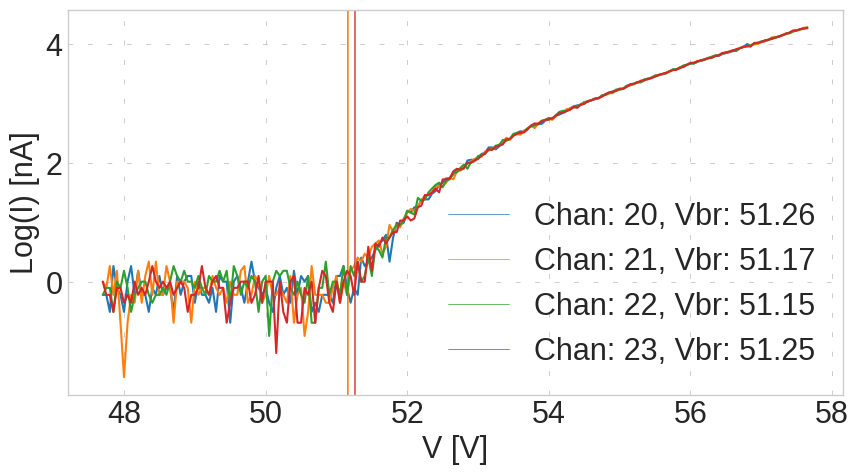

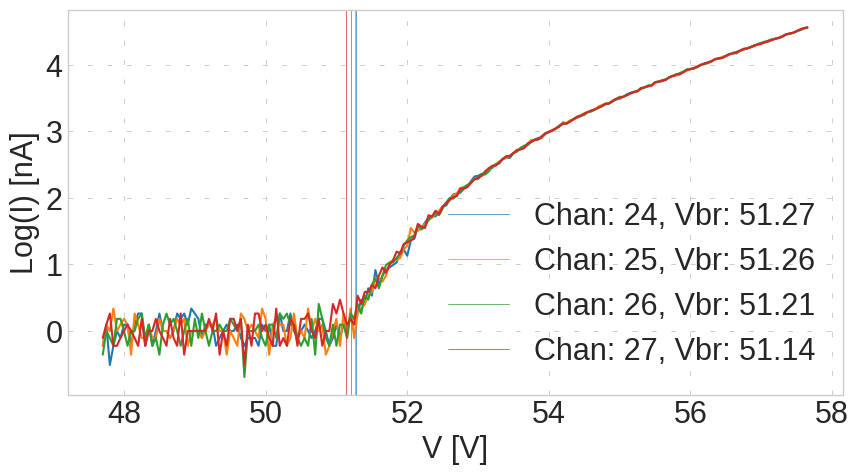

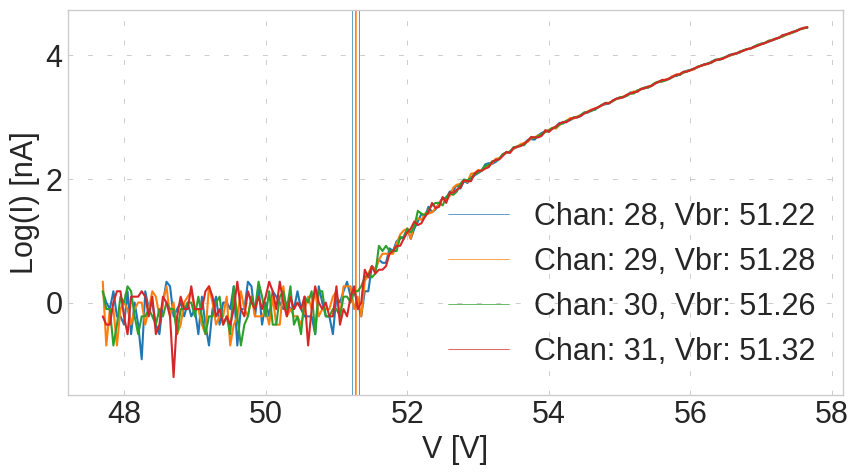

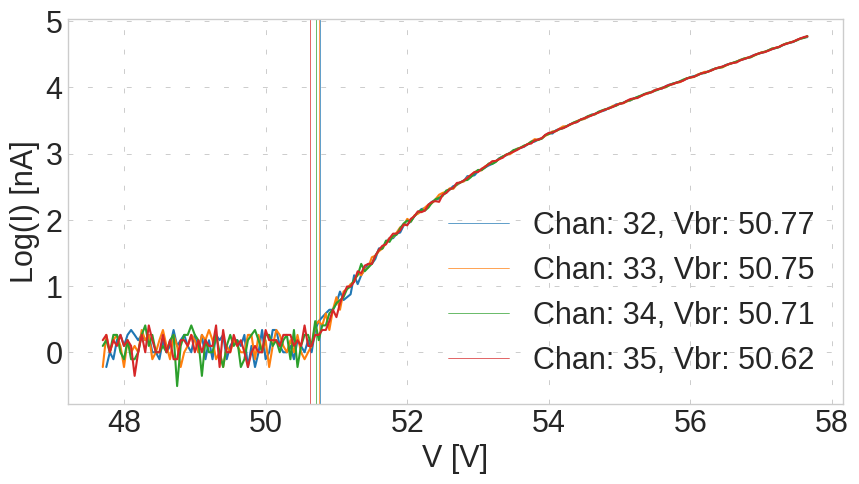

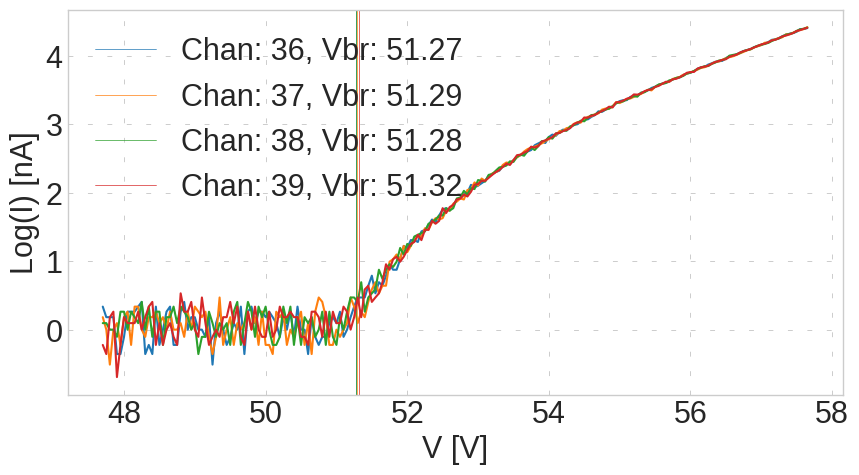

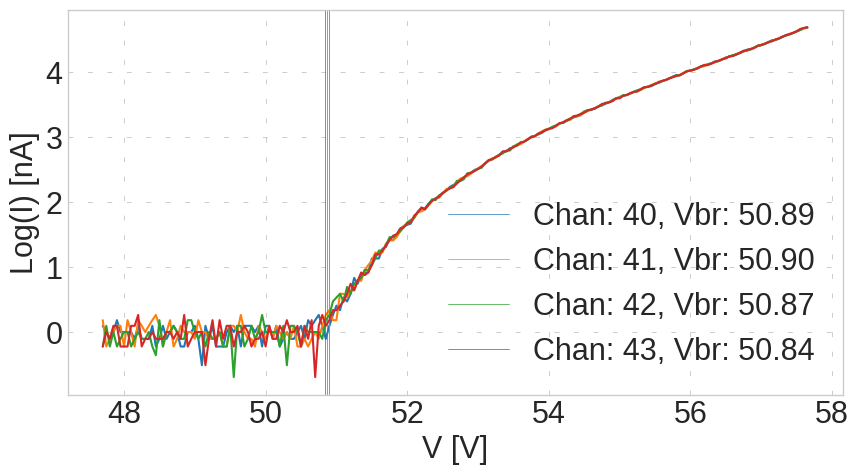

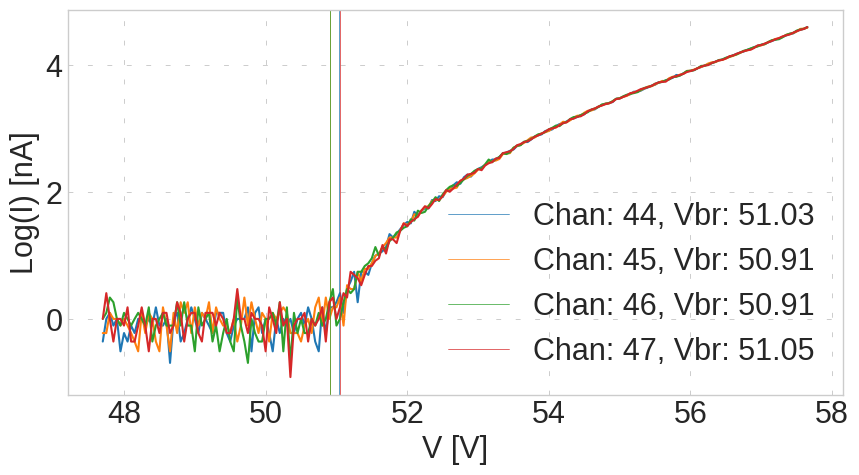

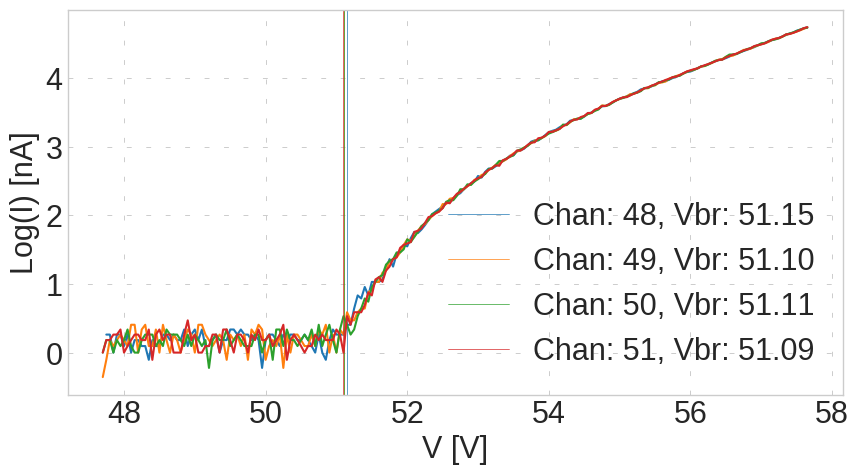

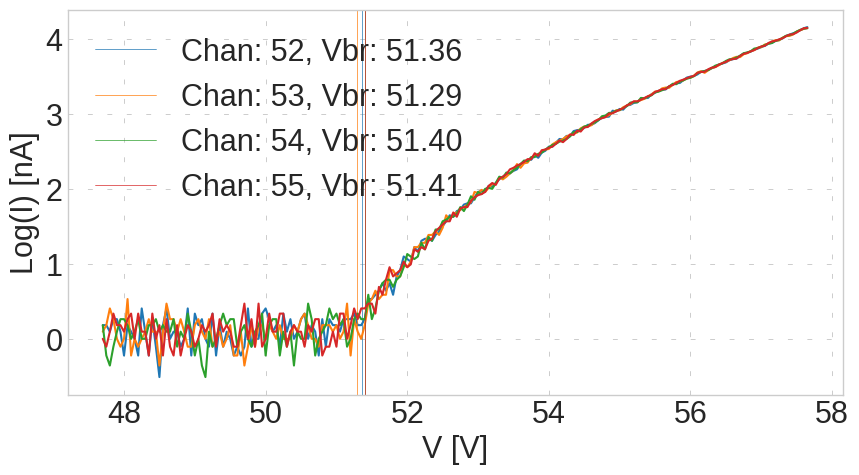

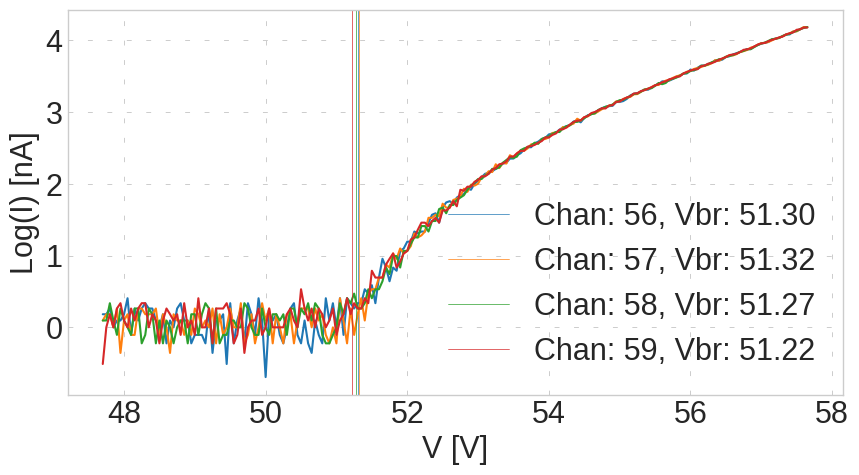

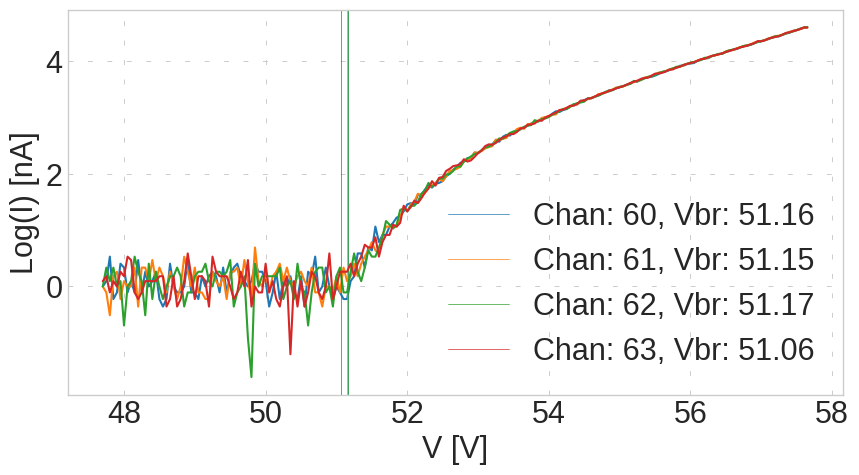

In [6]:
#Plot all channels
channels = df['chan'].unique()
channels = np.sort(channels)
for chan in channels:

    df2 = df.query('chan==%d'%chan)
    Vbr = df2['Vbr_fit'].iloc[0]

    if(chan%4 ==0):
        plt.figure()
    plts = plt.plot(df2.V, df2.I_log, '-')

    plt.axvline(x=Vbr, linestyle='-', color = plts[0].get_color(), linewidth=0.5,label='Chan: %d, Vbr: %.2f'%(chan, Vbr))
    plt.legend()
    plt.xlabel('V [V]')
    plt.ylabel('Log(I) [nA]')

Text(0.5, 1.0, 'Temp 10C')

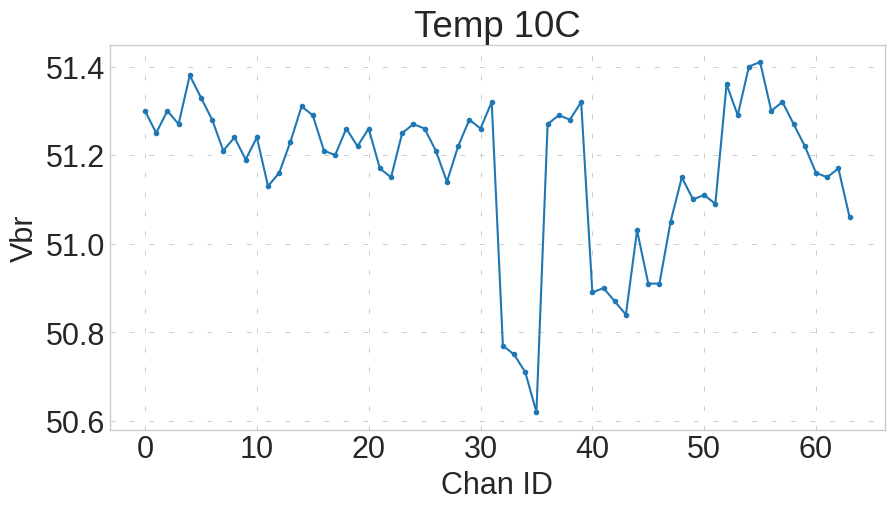

In [8]:
df_ = df.sort_values('chan').drop_duplicates(subset='chan')
plt.plot(df_['chan'], df_['Vbr_fit'], '.-')
#plt.ylim(51, 52.5)
plt.xlabel('Chan ID')
plt.ylabel('Vbr');
plt.title('Temp 10C')